In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

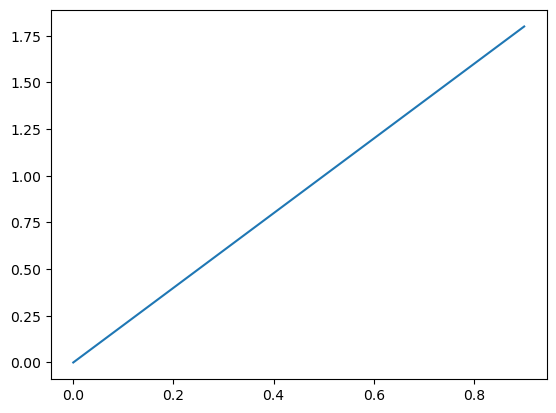

In [2]:
plt.plot(np.arange(0, 1, 0.1), 2*np.arange(0, 1, 0.1))

In [3]:
import h5py

In [34]:
from scipy.stats import norm

In [4]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
# import pandas as pd
import datetime
import os
# import readligo as rl
# from gwpy.timeseries import TimeSeries
import math
import random

import copy

In [5]:
epochs = 100
rTrain = 0.7;
rTest = 0.2;
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

### randomize bkg

In [63]:
with h5py.File("../data/Datasets/L1_bg_dataset_p1.hdf5") as f:
    print(f.keys())
    print(f["background_noise"].shape)
    print(f["background_noise_t0"][:])
    foo = f["background_noise"][:]

bkgn = np.empty((3*10**5, 200));

ind = 0;

for i in range(3000):
    for j in range(100):
        s = np.random.randint(low=4096, high=20480-200)
        bkgn[ind] = foo[i,s:s+200]
        ind = ind+1
        
bkgn = bkgn/np.array([np.linalg.norm(bkgn, axis=1)]).T

bkg2 = bkgn-np.mean([bkgn], axis=2).T
bkg2 = bkg2/np.std([bkg2], axis=2).T

<KeysViewHDF5 ['background_noise', 'background_noise_t0']>
(9915, 24576)
[1.23869024e+09 1.23869292e+09 1.23830585e+09 ... 1.23839411e+09
 1.23845594e+09 1.23839065e+09]


In [67]:
low = min(bkg2.flatten())
high = max(bkg2.flatten())

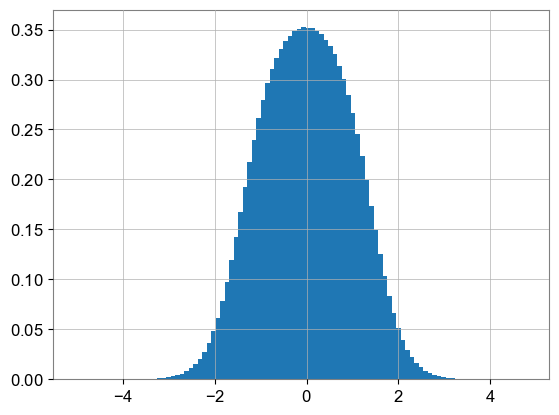

In [68]:
foo = plt.hist(bkg2.flatten(), range=(low, high), bins=100, density=True, label='Chia-Jui new noise')

In [96]:
np.digitize([-0.5, 0.5, 1.5, 2.5, 3.5], [1, 2, 3])

array([0, 0, 1, 2, 3], dtype=int64)

In [101]:
segments = np.cumsum(foo[0])*((high-low)/100);
offset = np.concatenate(([0], segments))
slope = ((high-low)/100) / (offset[1:] - offset[:-1])

C:\Users\sida_\AppData\Local\Temp\ipykernel_25796\2358731860.py:3: RuntimeWarning: divide by zero encountered in divide
  slope = ((high-low)/100) / (offset[1:] - offset[:-1])


In [103]:
strain = np.random.rand(200 * 10**5);
binIndex = np.digitize(strain, segments);
strain = strain - offset[binIndex];
strain = foo[1][binIndex] + strain*slope[binIndex]

In [104]:
strain = strain.reshape(10**5, 200)

In [117]:
strain2 = strain/np.linalg.norm([strain], axis=2).T

In [107]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(200, 40),nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(40, 200),nn.Tanh())

    def forward(self, x):
        encoded = self.layer1(x)
        decoded = self.layer2(encoded)
        return encoded, decoded

16240


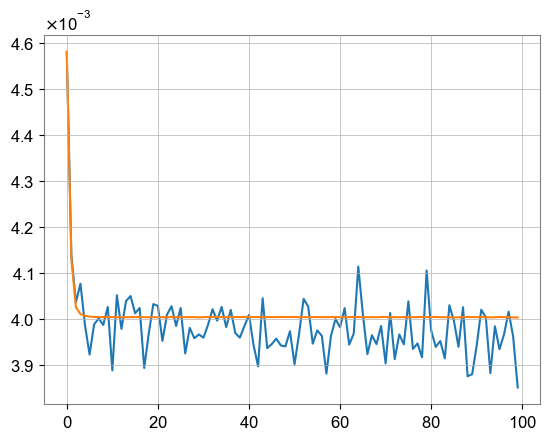

In [118]:
nTotal = len(strain2);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

X_train = strain2[perm[:nTrain]]
X_test = strain2[perm[-nTest:]]
X_validation = strain2[perm[nTrain:-nTest]]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
print(sum(p.numel() for p in autoencoder.parameters() if p.requires_grad))

optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

wNorm = 0

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
#     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

plt.plot(loss_train[:, 0])
plt.plot(loss_validation[:, 0])

torch.save(autoencoder.cuda(), "../data/Datasets/my_own_random_bkg.pt")

In [120]:
with h5py.File("../data/Datasets/bbh_dataset_p1.hdf5") as f:
    print(f["L1"].shape)
    print(f["bbh_L1"].shape)
    foo = f["L1"][:]

bbh = np.empty((10**5, 200));

ind = 0;

for i in range(1000):
    for j in range(100):
        s = np.random.randint(low=4096, high=3*4096-200) # signals are mainly injected at the first half, according to Chia-Jui
        bbh[ind] = foo[i,s:s+200]
        ind = ind+1
        
bbh = bbh/np.array([np.linalg.norm(bbh, axis=1)]).T

(4505, 24576)
(4505, 24576)


In [121]:
autoencoder.cpu().eval()

AutoEncoder(
  (layer1): Sequential(
    (0): Linear(in_features=200, out_features=40, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=40, out_features=200, bias=True)
    (1): Tanh()
  )
)

In [122]:
bkg_decoded = autoencoder(torch.FloatTensor(strain2))[1].detach().numpy()
bbh_decoded = autoencoder(torch.FloatTensor(bbh))[1].detach().numpy()

In [125]:
np.linalg.norm(strain2[:10], axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [126]:
np.linalg.norm(bbh[:10], axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

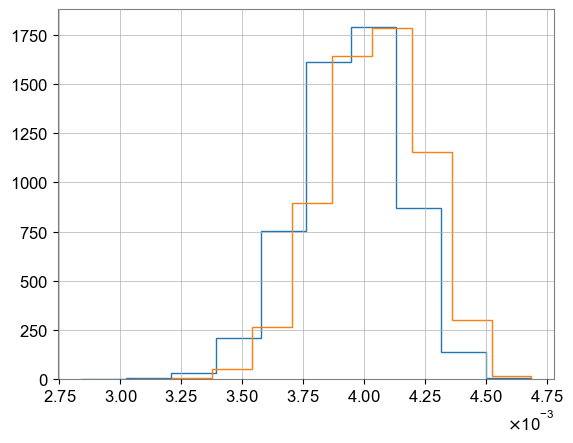

In [124]:
foo = plt.hist(np.var(strain2-bkg_decoded, axis=1), histtype="step", density=True)
foo = plt.hist(np.var(bbh - bbh_decoded, axis=1), histtype="step", density=True)

### testing the 1d CNN

In [51]:
bkg_gwak_0 = np.load("../data/Datasets/background.npz")['data'][:, 0, :];
bkg_gwak_0 = bkg_gwak_0 - np.mean([bkg_gwak_0], axis=2).T;
bkg_gwak_0 = bkg_gwak_0/np.std([bkg_gwak_0], axis=2).T;

bkg_gwak_1 = np.load("../data/Datasets/background.npz")['data'][:, 1, :];
bkg_gwak_1 = bkg_gwak_1 - np.mean([bkg_gwak_1], axis=2).T;
bkg_gwak_1 = bkg_gwak_1/np.std([bkg_gwak_1], axis=2).T;

In [14]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=50, kernel_size=3, stride=1, padding=1)# 100
        self.batch1 = nn.BatchNorm1d(num_features=50)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=4, return_indices=True)
        
        self.conv2 = nn.Conv1d(in_channels=50, out_channels=20, kernel_size=3, stride=1, padding=1)# 40
        self.batch2 = nn.BatchNorm1d(num_features=20)
        self.act2 = nn.ReLU()
#         self.pool2 = nn.MaxUnpool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(in_channels=20, out_channels=50, kernel_size=3, stride=1, padding=1)# 100
        self.batch3 = nn.BatchNorm1d(num_features=50)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxUnpool1d(kernel_size=4)
        
        self.conv4 = nn.Conv1d(in_channels=50, out_channels=1, kernel_size=3, padding=1)
        self.final = nn.Tanh()

    def forward(self, x):
#         print(x.shape)
        x = self.conv1(x);
        x = self.batch1(x);
        x = self.act1(x);
        x, indices = self.pool1(x);
#         print(x.shape)
#         x = self.pool1(self.act1(self.batch1(self.conv1(x))))
        encoded = self.act2(self.conv2(x))
#         print(encoded.shape)
        
        x = self.conv3(encoded)
        x = self.batch3(x);
        x = self.act3(x);
#         print(x.shape)
        x = self.pool3(x, indices);

#         x = self.final(self.conv4(x))
        x = self.conv4(x)

        return encoded, x

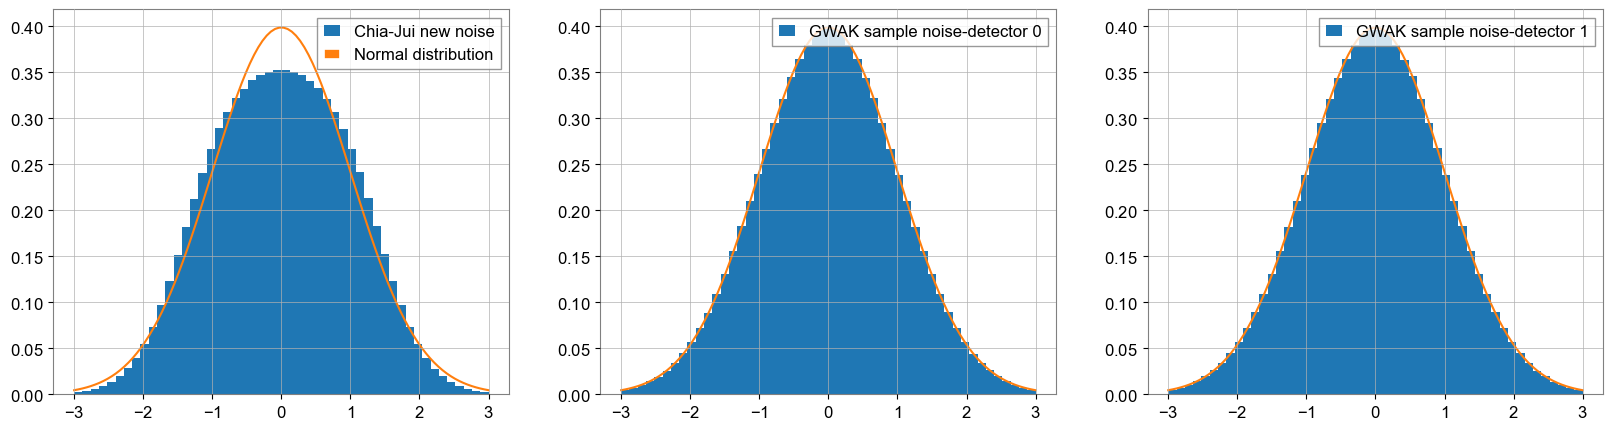

In [52]:
_, ax = plt.subplots(1, 3, figsize=(20, 5))
foo = ax[0].hist(bkg2.flatten(), range=(-3, 3), bins=50, density=True, label='Chia-Jui new noise')
ax[0].plot(np.linspace(-3, 3, 100), norm.pdf(np.linspace(-3, 3, 100)), label='Normal distribution')
ax[0].legend()

foo = ax[1].hist(bkg_gwak_0.flatten(), range=(-3, 3), bins=50, density=True, label="GWAK sample noise-detector 0")
ax[1].plot(np.linspace(-3, 3, 100), norm.pdf(np.linspace(-3, 3, 100)))
ax[1].legend()

foo = ax[2].hist(bkg_gwak_1.flatten(), range=(-3, 3), bins=50, density=True, label="GWAK sample noise-detector 1")
ax[2].plot(np.linspace(-3, 3, 100), norm.pdf(np.linspace(-3, 3, 100)))
ax[2].legend()

plt.savefig("../results/noise_amp_comparison.jpg")
plt.show()

6661
37.81891632080078
Epoch: 0001, Training loss=0.02146615, Validation loss=0.01909738
36.561570167541504
Epoch: 0002, Training loss=0.01033202, Validation loss=0.01158973
31.160659551620483
Epoch: 0003, Training loss=0.00841966, Validation loss=0.00863043
30.246778964996338
Epoch: 0004, Training loss=0.00848730, Validation loss=0.00754700
29.193392992019653
Epoch: 0005, Training loss=0.00613675, Validation loss=0.00671803
27.853121995925903
Epoch: 0006, Training loss=0.00630415, Validation loss=0.00637204
27.28664779663086
Epoch: 0007, Training loss=0.00549162, Validation loss=0.00586967
28.300755977630615
Epoch: 0008, Training loss=0.00564254, Validation loss=0.00557804
31.780978679656982
Epoch: 0009, Training loss=0.00650099, Validation loss=0.00532973
31.770010471343994
Epoch: 0010, Training loss=0.00590884, Validation loss=0.00509850
31.275696277618408
Epoch: 0011, Training loss=0.00551035, Validation loss=0.00501270
28.923948526382446
Epoch: 0012, Training loss=0.00473411, Vali

26.948599815368652
Epoch: 0098, Training loss=0.00334141, Validation loss=0.00336577
29.19945788383484
Epoch: 0099, Training loss=0.00347148, Validation loss=0.00370147
27.261006832122803
Epoch: 0100, Training loss=0.00327441, Validation loss=0.00328393


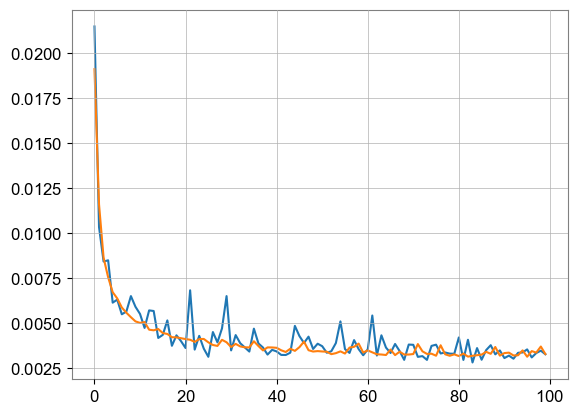

In [15]:
trainData = torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])))
testData = torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1])))
validationData = torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1])))

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
print(sum(p.numel() for p in autoencoder.parameters() if p.requires_grad))

optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

wNorm = 0

for epoch in range(epochs):
    
    t0 = time.time()

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print(time.time() - t0)
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

plt.plot(loss_train[:, 0])
plt.plot(loss_validation[:, 0])


In [16]:
autoencoder.eval().cpu()

AutoEncoder(
  (conv1): Conv1d(1, 50, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(50, 20, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (conv3): Conv1d(20, 50, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU()
  (pool3): MaxUnpool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (conv4): Conv1d(50, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (final): Tanh()
)

In [17]:
decoded_bkgTrain = np.empty(X_train.shape)

for i in range(X_train.shape[0]//1000):
    foo = autoencoder(torch.FloatTensor(X_train[i*1000:(i+1)*1000].reshape((1000,1,X_train.shape[1]))))
    decoded_bkgTrain[i*1000:(i+1)*1000] = foo[1].detach().numpy().reshape(1000, X_train.shape[1])

In [18]:
decoded_bkgTest = np.empty(X_test.shape)

for i in range(X_test.shape[0]//1000):
    foo = autoencoder(torch.FloatTensor(X_test[i*1000:(i+1)*1000].reshape((1000,1,X_test.shape[1]))))
    decoded_bkgTest[i*1000:(i+1)*1000] = foo[1].detach().numpy().reshape(1000, X_test.shape[1])

In [19]:
decoded_bbh = np.empty(bbh2.shape)

for i in range(bbh2.shape[0]//1000):
    foo = autoencoder(torch.FloatTensor(bbh2[i*1000:(i+1)*1000].reshape((1000,1,bbh2.shape[1]))))
    decoded_bbh[i*1000:(i+1)*1000] = foo[1].detach().numpy().reshape(1000, bbh2.shape[1])

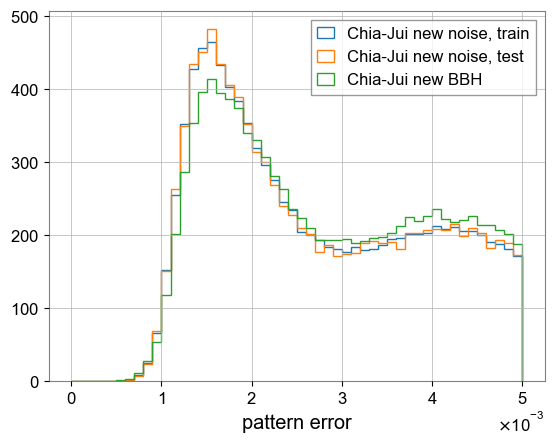

In [20]:
foo1 = plt.hist(np.mean((X_train-decoded_bkgTrain)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new noise, train", histtype="step")
foo2 = plt.hist(np.mean((X_test-decoded_bkgTest)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new noise, test", histtype="step")
foo3 = plt.hist(np.mean((bbh2-decoded_bbh)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new BBH", histtype="step")

plt.xlabel("pattern error")
plt.legend()

In [21]:
torch.save(autoencoder.cuda(), "../data/Datasets/model_CNN_2.pt")
# np.savetxt("../data/Datasets/loss_CNN_Xcheck_ChiaJui_data.dat", [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/Datasets/perm_CNN_2.dat", perm)

In [193]:
import json

In [205]:
dic = {"bin_boundaries":list(foo1[1]), "bin_train":list(foo1[0]), "bin_test":list(foo2[0]), "bin_bbh":list(foo3[0])};

In [206]:
with open("../data/Datasets/CNN_bins.json", "w") as f:
    json.dump(dic, f)

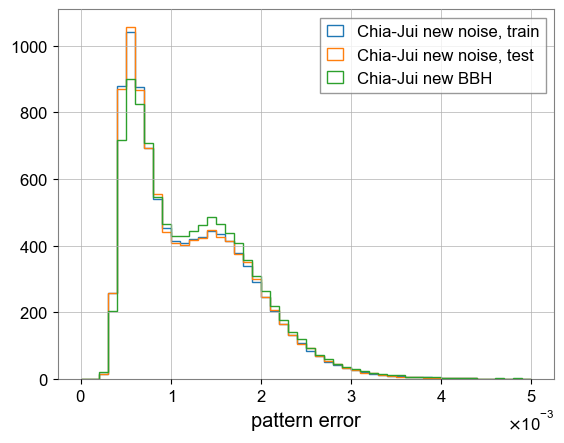

In [182]:
# foo = plt.hist(np.mean((bbh2-decoded_bbh)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new BBH")
foo = plt.hist(np.mean((X_train-decoded_bkgTrain)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new noise, train", histtype="step")
foo = plt.hist(np.mean((X_test-decoded_bkgTest)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new noise, test", histtype="step")
foo = plt.hist(np.mean((bbh2-decoded_bbh)**2, axis=1), density=True, range=(0, 0.005), bins=50, label="Chia-Jui new BBH", histtype="step")

plt.xlabel("pattern error")
plt.legend()
plt.savefig("../results/CNN_pattern_error.jpg")

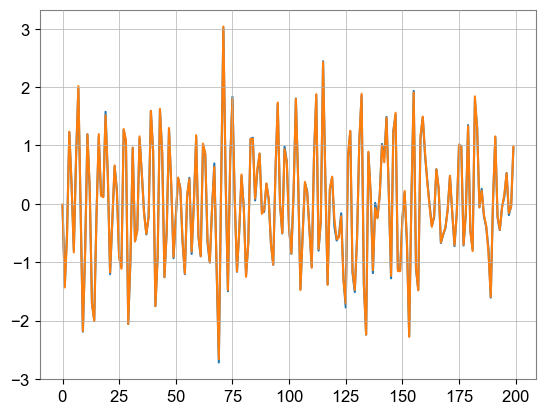

In [170]:
plt.plot(X_train[0])
plt.plot(decoded_bkgTrain[0])

### testing Chia-Jui's data

In [62]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(200, 100),nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(100, 40),nn.ReLU())
        
        self.layer3 = nn.Sequential(nn.Linear(40, 100),nn.ReLU())
        self.layer4 = nn.Sequential(nn.Linear(100, 200),nn.Tanh())

    def forward(self, x):
        encoded = self.layer2(self.layer1(x))
        decoded = self.layer4(self.layer3(encoded))
        return encoded, decoded

In [6]:
with h5py.File("../data/Datasets/L1_bg_dataset_p1.hdf5") as f:
    print(f.keys())
    print(f["background_noise"].shape)
    print(f["background_noise_t0"][:])
    foo = f["background_noise"][:]

<KeysViewHDF5 ['background_noise', 'background_noise_t0']>
(9915, 24576)
[1.23869024e+09 1.23869292e+09 1.23830585e+09 ... 1.23839411e+09
 1.23845594e+09 1.23839065e+09]


In [12]:
foo.shape

(9915, 24576)

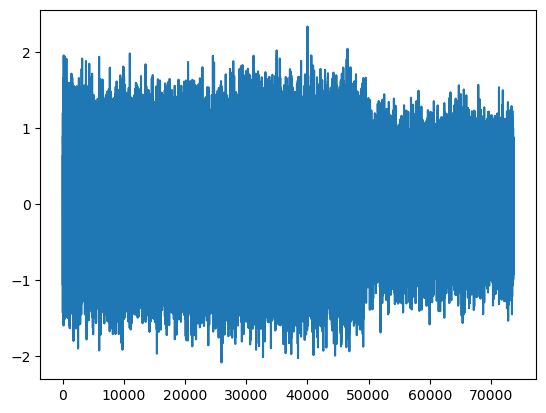

In [16]:
plt.plot(np.concatenate((foo[0], foo[1], foo[2])))

In [7]:
bkg = np.empty((3*10**5, 200));

ind = 0;

for i in range(3000):
    for j in range(100):
        s = np.random.randint(low=4096, high=20480-200)
        bkg[ind] = foo[i,s:s+200]
        ind = ind+1
        
bkg = bkg/np.array([np.linalg.norm(bkg, axis=1)]).T

In [8]:
with h5py.File("../data/Datasets/bbh_dataset_p1.hdf5") as f:
    print(f["L1"].shape)
    print(f["bbh_L1"].shape)
    foo = f["L1"][:]

(4505, 24576)
(4505, 24576)


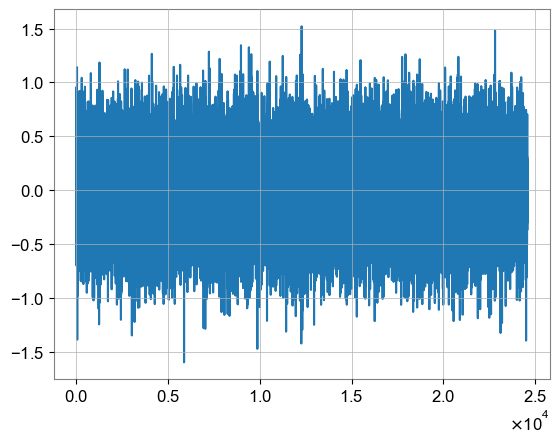

In [37]:
plt.plot(foo[0])

In [9]:
bbh = np.empty((10**5, 200));

ind = 0;

for i in range(1000):
    for j in range(100):
        s = np.random.randint(low=4096, high=3*4096-200) # signals are mainly injected at the first half, according to Chia-Jui
        bbh[ind] = foo[i,s:s+200]
        ind = ind+1
        
bbh = bbh/np.array([np.linalg.norm(bbh, axis=1)]).T

In [70]:
bbh.shape

(100000, 200)

In [10]:
bbh

array([[ 0.02304348, -0.03801842,  0.04185165, ...,
        -0.12397217,  0.02402944,  0.03023142],
       [-0.17438949, -0.10874302, -0.07639478, ...,
        -0.02280171,  0.06709912,  0.03172942],
       [-0.00482613, -0.05617971, -0.00263441, ...,
         0.04202695, -0.06844651, -0.05672267],
       ...,
       [-0.08140836, -0.01664715, -0.01376178, ...,
        -0.01742034, -0.0554502 , -0.0590132 ],
       [ 0.09182206,  0.01741503, -0.1355899 , ...,
         0.07700598, -0.01937028, -0.01032383],
       [-0.08585392, -0.02571368, -0.06190922, ...,
         0.06471734,  0.02632406, -0.03476397]])

In [11]:
bbh2 = bbh-np.mean([bbh], axis=2).T
bbh2 = bbh2/np.std([bbh2], axis=2).T

bkg2 = bkg-np.mean([bkg], axis=2).T
bkg2 = bkg2/np.std([bkg2], axis=2).T

In [12]:
# nTotal = len(bkg);
# # nTotal = len(fake_bkg);
# nTrain = int(rTrain * nTotal)
# nTest = int(rTest * nTotal)

# perm = np.random.permutation(nTotal)

# X_train = bkg[perm[:nTrain]]
# X_test = bkg[perm[-nTest:]]
# X_validation = bkg[perm[nTrain:-nTest]]

# # X_train = fake_bkg[perm[:nTrain]]
# # X_test = fake_bkg[perm[-nTest:]]
# # X_validation = fake_bkg[perm[nTrain:-nTest]]

nTotal = len(bkg2);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

X_train = bkg2[perm[:nTrain]]
X_test = bkg2[perm[-nTest:]]
X_validation = bkg2[perm[nTrain:-nTest]]

In [13]:
epochs = 100

48440
Epoch: 0001, Training loss=0.56656837, Validation loss=0.48602720
Epoch: 0002, Training loss=0.43690217, Validation loss=0.44172252
Epoch: 0003, Training loss=0.45236853, Validation loss=0.42001011
Epoch: 0004, Training loss=0.39279816, Validation loss=0.40699871
Epoch: 0005, Training loss=0.44616362, Validation loss=0.39863662
Epoch: 0006, Training loss=0.39418554, Validation loss=0.39340850
Epoch: 0007, Training loss=0.33843970, Validation loss=0.38968708
Epoch: 0008, Training loss=0.41101265, Validation loss=0.38724034
Epoch: 0009, Training loss=0.36607322, Validation loss=0.38521878
Epoch: 0010, Training loss=0.45901656, Validation loss=0.38378148
Epoch: 0011, Training loss=0.33316016, Validation loss=0.38259282
Epoch: 0012, Training loss=0.47816730, Validation loss=0.38159287
Epoch: 0013, Training loss=0.43753508, Validation loss=0.38058565
Epoch: 0014, Training loss=0.34536299, Validation loss=0.37956624
Epoch: 0015, Training loss=0.38400596, Validation loss=0.37904435
Epoc

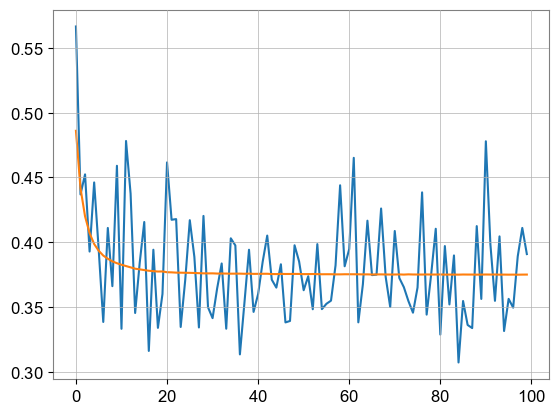

In [87]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
print(sum(p.numel() for p in autoencoder.parameters() if p.requires_grad))

optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

wNorm = 0

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

plt.plot(loss_train[:, 0])
plt.plot(loss_validation[:, 0])

torch.save(autoencoder.cuda(), "../data/Datasets/model_200-40_Xcheck_ChiaJui_data.pt")
np.savetxt("../data/Datasets/loss_Xcheck_ChiaJui_data.dat", [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/Datasets/perm_Xcheck_ChiaJui_data.dat", perm)

In [88]:
autoencoder.eval().cpu()

AutoEncoder(
  (layer1): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=40, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): Tanh()
  )
)

In [94]:
_, decoded_bkgTrain = autoencoder(torch.FloatTensor(X_train))
_, decoded_bkgTest = autoencoder(torch.FloatTensor(X_test))
_, decoded_bbh = autoencoder(torch.FloatTensor(bbh2))

decoded_bkgTrain = decoded_bkgTrain.detach().numpy()
decoded_bkgTest = decoded_bkgTest.detach().numpy()
decoded_bbh = decoded_bbh.detach().numpy()

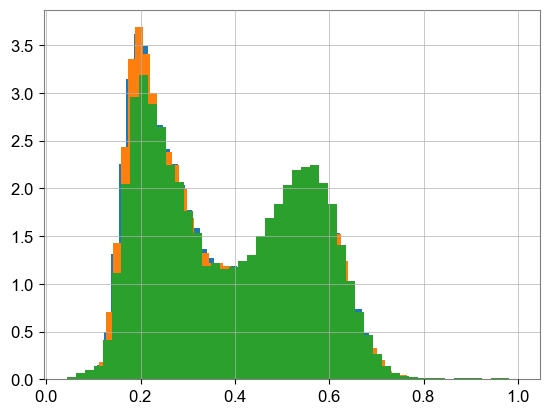

In [95]:
foo = plt.hist(np.mean((X_train-decoded_bkgTrain)**2, axis=1), density=True, bins=50)
foo = plt.hist(np.mean((X_test-decoded_bkgTest)**2, axis=1), density=True, bins=50)
foo = plt.hist(np.mean((bbh2-decoded_bbh)**2, axis=1), density=True, bins=50)

### previous 201-dim DNN

In [82]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(201, 40),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(40, 201),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [64]:
renorm_factor = 20;

In [7]:
bkg_raw = np.load("../data/Datasets/background.npz")['data'][:, 0, :];
bbh_raw = np.load("../data/Datasets/bbh_for_challenge.npy")[:, 0, :];

In [87]:
fake_bkg = np.load("../data/4000Hz25msnoisesample1e6.npy")[100:2*10**5].reshape((10**5-50, 200)) * 1e21

In [46]:
np.mean(bkg[:, -1])

0.47706871687769986

In [47]:
np.mean(bbh[:, -1])

0.4862724306077037

In [52]:
np.mean(fake_bkg[:, -1])

0.46630769353527923

In [34]:
norm = np.transpose([np.linalg.norm(bkg_raw, axis = 1)]);
bkg = np.hstack((bkg_raw/norm, norm / renorm_factor))

norm = np.transpose([np.linalg.norm(bbh_raw, axis = 1)]);
bbh = np.hstack((bbh_raw/norm, norm / renorm_factor))

In [88]:
norm = np.transpose([np.linalg.norm(fake_bkg, axis = 1)]);
fake_bkg = np.hstack((fake_bkg/norm, norm))

In [18]:
# bkg = bkg[::10]

In [90]:
# nTotal = len(bkg);
nTotal = len(fake_bkg);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

# X_train = bkg[perm[:nTrain]]
# X_test = bkg[perm[-nTest:]]
# X_validation = bkg[perm[nTrain:-nTest]]

X_train = fake_bkg[perm[:nTrain]]
X_test = fake_bkg[perm[-nTest:]]
X_validation = fake_bkg[perm[nTrain:-nTest]]

In [92]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

for wNorm in [0, 0.1, 1, 10, 100, 1000]:

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    loss_train = np.zeros((epochs, 1))
    loss_validation = np.zeros((epochs, 1))
    t0 = time.time()

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            # weighted_lossTrain = loss_func(decoded, x)
            loss_overall = loss_func(decoded, x)
            loss_norm = loss_func(decoded[:, -1], x[:, -1])
            weighted_lossTrain = loss_overall + loss_norm * wNorm

            # output_norm = torch.norm(decoded[:, :100], dim=1) 
            # penalty_term = torch.mean((output_norm - 1) ** 2) 
            # weighted_lossTrain = lossTrain + coef_delta * penalty_term

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()

        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, _) in enumerate(validationDataLoader):
                x = x.cuda()
                encoded, decoded = autoencoder(x)
                lossVal_overall = loss_func(decoded, x)
                lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
                lossVal = lossVal_overall + lossVal_norm * wNorm
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch,0] = weighted_lossTrain.item()
        loss_validation[epoch,0] = val_loss
    #     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

    print(time.time() - t0)
    print("Norm weight %f done training" % (wNorm,))
    print(autoencoder.cuda())
    torch.save(autoencoder.cuda(), "../data/model_201-40_weight_%f_fakebkg.pt" % (wNorm,))
    np.savetxt("../data/loss_201-40_weight_%f_fakebkg.dat" % (wNorm,), [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/perm_fakebkg.dat", perm)

1100.9891967773438
Norm weight 0.000000 done training
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=201, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=201, bias=True)
    (1): Tanh()
  )
)
1056.5638000965118
Norm weight 0.100000 done training
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=201, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=201, bias=True)
    (1): Tanh()
  )
)
1068.1610398292542
Norm weight 1.000000 done training
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=201, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=201, bias=True)
    (1): Tanh()
  )
)
1083.5941903591156
Norm weight 10.000000 done training
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=201, out_features=40, bias=True)
   

KeyboardInterrupt: 

# 4-AE, series, updated training

In [7]:
renorm_factor = 20;

realbkg = np.load("../data/Datasets/background.npz")['data'] / renorm_factor;
realbbh = np.load("../data/Datasets/bbh_for_challenge.npy") / renorm_factor;

realsg = np.load("../data/Datasets/sglf_for_challenge.npy") / renorm_factor;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch = np.load("../data/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"]

# perm = np.random.permutation(len(realbkg))
perm = np.loadtxt("../data/perm_4ae_bkg.dat").astype("int");
bkg = realbkg[perm, 0][:int(len(perm)*0.7)]
bkg_reserved = realbkg[perm, 0][int(len(perm)*0.7):]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bkg.dat", perm)

# perm = np.random.permutation(len(realbbh))
perm = np.loadtxt("../data/perm_4ae_bbh.dat").astype("int");
bbh = realbbh[perm, 0][:int(len(perm)*0.7)]
bbh_reserved = realbbh[perm, 0][int(len(perm)*0.7):]
bbh = bbh/np.linalg.norm([bbh], axis=2).T
bbh_reserved = bbh_reserved/np.linalg.norm([bbh_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bbh.dat", perm)

# perm = np.random.permutation(len(realsg))
perm = np.loadtxt("../data/perm_4ae_sg.dat").astype("int");
sg = realsg[perm, 0][:int(len(perm)*0.7)]
sg_reserved = realsg[perm, 0][int(len(perm)*0.7):]
sg = sg/np.linalg.norm([sg], axis=2).T
sg_reserved = sg_reserved/np.linalg.norm([sg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_sg.dat", perm)

# perm = np.random.permutation(len(realglitch))
perm = np.loadtxt("../data/perm_4ae_glitch.dat").astype("int");
glitch = realglitch[perm][:int(len(perm)*0.7)]
glitch_reserved = realglitch[perm][int(len(perm)*0.7):]
glitch = glitch/np.linalg.norm([glitch], axis=2).T
glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_glitch.dat", perm)

In [8]:
bkg_fft = abs(np.fft.rfft(bkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T
bkg_reserved_fft = abs(np.fft.rfft(bkg_reserved))
bkg_reserved_fft = bkg_reserved_fft/np.linalg.norm([bkg_reserved_fft], axis=2).T

bbh_fft = abs(np.fft.rfft(bbh))
bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T
bbh_reserved_fft = abs(np.fft.rfft(bbh_reserved))
bbh_reserved_fft = bbh_reserved_fft/np.linalg.norm([bbh_reserved_fft], axis=2).T

sg_fft = abs(np.fft.rfft(sg))
sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T
sg_reserved_fft = abs(np.fft.rfft(sg_reserved))
sg_reserved_fft = sg_reserved_fft/np.linalg.norm([sg_reserved_fft], axis=2).T

glitch_fft = abs(np.fft.rfft(glitch))
glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T
glitch_reserved_fft = abs(np.fft.rfft(glitch_reserved))
glitch_reserved_fft = glitch_reserved_fft/np.linalg.norm([glitch_reserved_fft], axis=2).T

In [14]:
c0 = {};

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

## finding a rough boundary for the stepwise filtering

In [ ]:
# Ncut = 10;

# max_glitch = 0.0026;
# min_glitch = 0.001;

In [106]:
list_datatype = ["noise", "bbh", "sg", "glitch"];

### Step 1: glitch

In [11]:
models = {};
models["glitch"] = torch.load("../data/4ae_3.pt")
models["glitch"].cpu().eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=101, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=101, bias=True)
    (1): Sigmoid()
  )
)

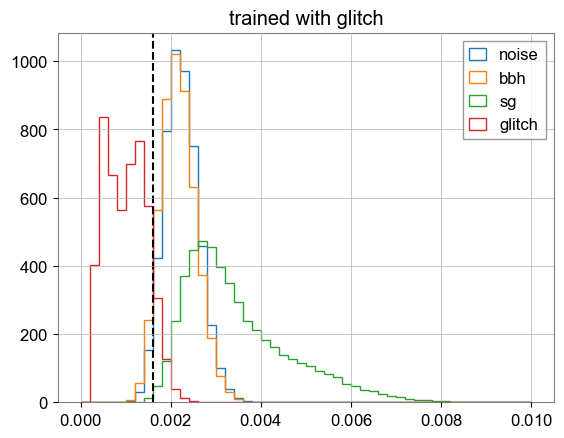

In [18]:
model = models["glitch"]

c0["glitch"] = 0.0016;

dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
plt.axvline(c0["glitch"], color="k", linestyle="--")
plt.legend()

In [ ]:
bkg_filtered = bkg_fft
sg_filtered = sg_fft
bbh_filtered = bbh_fft

### Step 2: noise

In [35]:
currentStep = "noise"

In [25]:
previousStep = "glitch"
bkg_filtered = bkg_fft[np.var(bkg_fft-dcd_bkg, axis=1)>=c0[previousStep]]
sg_filtered = sg_fft[np.var(sg_fft-dcd_sg, axis=1)>=c0[previousStep]]
bbh_filtered = bbh_fft[np.var(bbh_fft-dcd_bbh, axis=1)>=c0[previousStep]]

In [26]:
bkg_filtered.shape

(67363, 101)

In [38]:
t0 = time.time()
dataset = bkg_filtered;

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

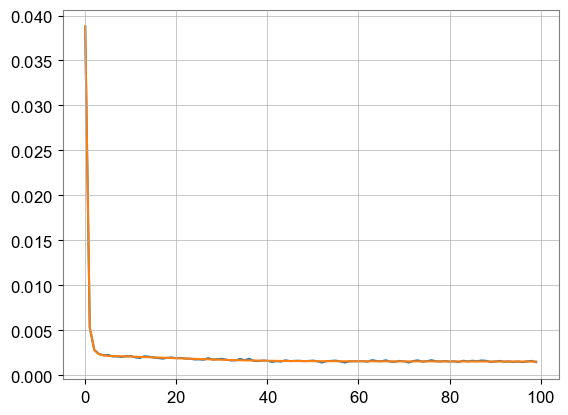

In [39]:
plt.plot(loss_train)
plt.plot(loss_validation)

In [43]:
autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

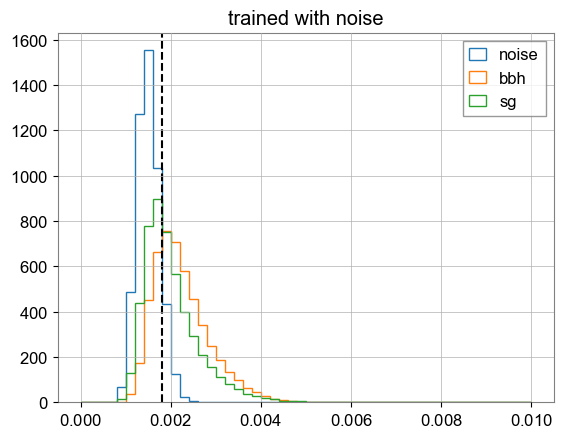

In [46]:
model = models[currentStep]

c0[currentStep] = 0.0018;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

### Step 3: BBH

In [47]:
c0

{'glitch': 0.0016, 'noise': 0.0018}

In [50]:
previousStep = currentStep
currentStep = "bbh"
print("from "+previousStep+" to "+currentStep)

In [51]:
# bkg_filtered = bkg_fft[np.var(bkg_fft-dcd_bkg, axis=1)>=c0[previousStep]]
sg_filtered = sg_filtered[np.var(sg_filtered-dcd_sg, axis=1)>=c0[previousStep]]
bbh_filtered = bbh_filtered[np.var(bbh_filtered-dcd_bbh, axis=1)>=c0[previousStep]]

In [53]:
bbh_filtered.shape

(48327, 101)

109.44433689117432


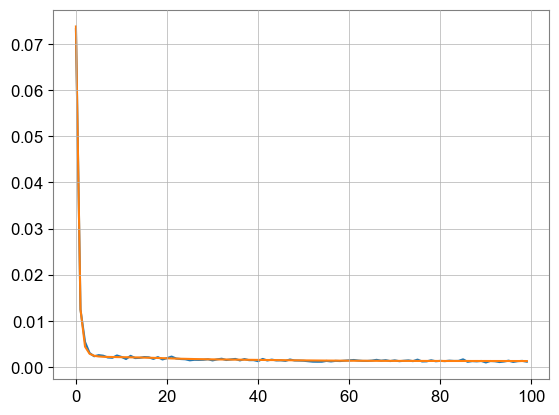

In [54]:
t0 = time.time()
dataset = bbh_filtered;

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

In [55]:
autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

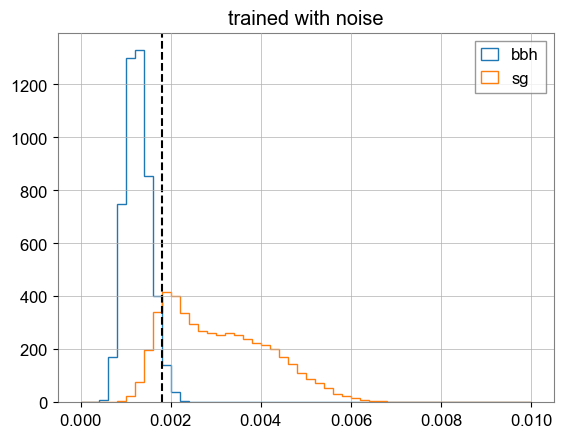

In [57]:
model = models[currentStep]

c0[currentStep] = 0.0018;

# dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

### Step 4: SG

In [59]:
c0

{'glitch': 0.0016, 'noise': 0.0018, 'bbh': 0.0018}

In [61]:
previousStep = "bbh"
currentStep = "sg"
print("from "+previousStep+" to "+currentStep)

from bbh to sg


In [62]:
# bkg_filtered = bkg_fft[np.var(bkg_fft-dcd_bkg, axis=1)>=c0[previousStep]]
sg_filtered = sg_filtered[np.var(sg_filtered-dcd_sg, axis=1)>=c0[previousStep]]
# bbh_filtered = bbh_filtered[np.var(bbh_filtered-dcd_bbh, axis=1)>=c0[previousStep]]

In [63]:
sg_filtered.shape

(33443, 101)

80.09750008583069


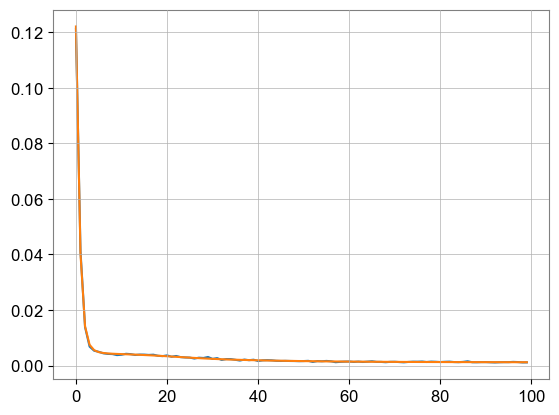

In [64]:
t0 = time.time()
dataset = sg_filtered;

nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    
plt.plot(loss_train)
plt.plot(loss_validation)

print(time.time() - t0)

In [65]:
autoencoder.cpu().eval();
models[currentStep] = copy.deepcopy(autoencoder);

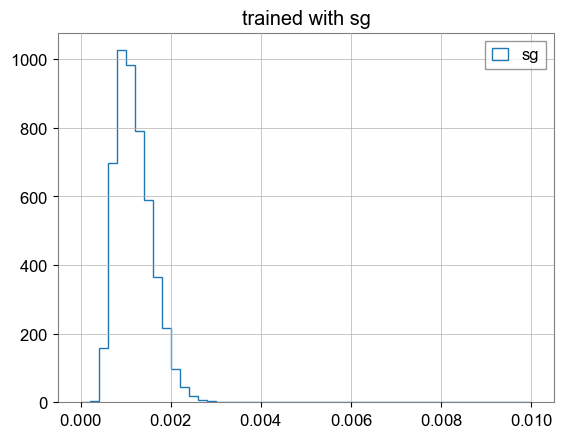

In [67]:
model = models[currentStep]

# c0[currentStep] = 0.0018;

# dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
# dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with sg")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.legend()

In [68]:
print(sum(p.numel() for p in autoencoder.parameters() if p.requires_grad))

4161


## streamline of the sequential training

In [98]:
version = "v1";

In [87]:
N_bkg = len(bkg_reserved_fft);
N_glitch = int(N_bkg/15);
N_bbh = int(N_bkg*2/15);
N_sg = int(N_bkg*2/15);

testset = np.empty((N_bkg+N_glitch+N_bbh+N_sg, len(bkg_reserved_fft[0])))

s = 0;
testset[s : s+N_glitch] = glitch_reserved_fft[np.random.permutation(len(glitch_reserved_fft))[:N_glitch]];
s += N_glitch;

testset[s : s+N_bkg] = bkg_reserved_fft[np.random.permutation(len(bkg_reserved_fft))[:N_bkg]];
s += N_bkg;

testset[s : s+N_bbh] = bbh_reserved_fft[np.random.permutation(len(bbh_reserved_fft))[:N_bbh]];
s += N_bbh;

testset[s : s+N_sg] = sg_reserved_fft[np.random.permutation(len(sg_reserved_fft))[:N_sg]];
s += N_sg;

correct_ans = np.concatenate(([0]*N_glitch, [1]*N_bkg, [2]*N_bbh, [3]*N_sg))

Nsample = {};
Nsample["glitch"] = N_glitch;
Nsample["noise"] = N_bkg;
Nsample["bbh"] = N_bbh;
Nsample["sg"] = N_sg

In [75]:
# epochs = 50;

# datatype2ind = {"glitch":0, "noise":1, "bbh":2, "sg":3};
# ind2datatype = {};
# for key in datatype2ind.keys():
#     ind2datatype[datatype2ind[key]] = key

In [101]:
epochs = 50;

# arranging the sequences of the series
ind2datatype = {0:"glitch", 1:"noise", 2:"bbh", 3:"sg"}
datatype2ind = {};
for key in ind2datatype.keys():
    datatype2ind[ind2datatype[key]] = key
    
torch.save(ind2datatype, "../data/SequentialTraining/sequence_"+version+".json")

In [76]:
Ncut = 5;
cutList = {};

max_glitch = 0.0026;
min_glitch = 0.001;
cutList["glitch"] = np.linspace(min_glitch, max_glitch, Ncut);

max_bkg = 0.0026;
min_bkg = 0.001;
cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);

max_bbh = 0.0024;
min_bbh = 0.0008;
cutList["bbh"] = np.linspace(min_bbh, max_bbh, Ncut);

max_sg = 0.003;
min_sg = 0.0003;
cutList["sg"] = np.linspace(min_sg, max_sg, Ncut);

In [99]:
torch.save(cutList, "../data/SequentialTraining/cut_"+version+".json")

In [ ]:
models = {};
models["glitch"] = torch.load("../data/4ae_3.pt")
models["glitch"].cpu().eval()

In [90]:
def trainAE(dataset):
    
    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData, trainData)
    test_dataset = TensorDataset(testData, testData)
    validation_dataset = TensorDataset(validationData, validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()

    wNorm = 0;

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
    return autoencoder.cpu().eval()

In [100]:
import itertools

In [107]:
cnt = 0;

ic = np.zeros(4, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
ic[3] = Ncut-1;

listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1], ic[2] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):

    data_filtered = {};
    data_filtered["noise"] = bkg_fft;
    data_filtered["bbh"] = bbh_fft;
    data_filtered["sg"] = sg_fft;
    
    for iPrev in range(3):
        previousStep = ind2datatype[iPrev];
        modelPrev = models[previousStep];
        
        # filter the data
        for j in range(iPrev+1, 4):
            dt = ind2datatype[j];
            dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
            data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
            
        currentStep = ind2datatype[iPrev+1];
        model = trainAE(data_filtered[currentStep]);
        models[currentStep] = model;
        
    torch.save(models, "../data/SequentialTraining/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
    
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    for datatype in list_datatype:
        dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
        err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
    not_select = np.array([True]*len(testset));

    for iStep in range(len(list_datatype)):
        datatype = ind2datatype[iStep];
        ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
        ans[ind_pass] = iStep;
        not_select[ind_pass] = False;
        
    ans[not_select] = -1;
    
    listResult["cut"][cnt] = ic;
    listResult["ans"][cnt] = ans;
    
    acc = np.zeros(len(ind2datatype));
    
    for i in range(len(ind2datatype)):
        acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
    listResult["accuracy_4"][cnt] = acc;
    
    listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
                                     np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    
    cnt += 1;
    print(cnt)
    
listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

C:\Users\sida_\AppData\Local\Temp\ipykernel_15476\861529380.py:66: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]),
C:\Users\sida_\AppData\Local\Temp\ipykernel_15476\861529380.py:67: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125


In [126]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_4"] >= 0.01*A, axis=1))/len(listResult["accuracy_4"])] for A in range(101)])

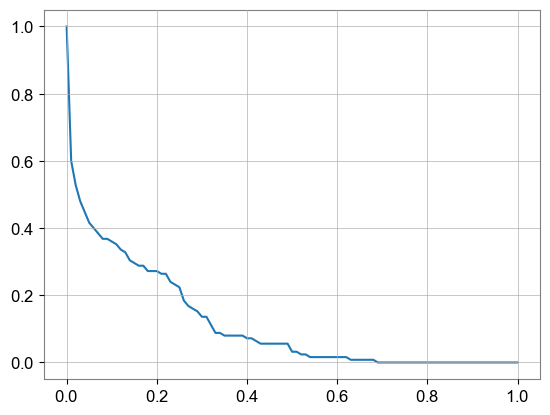

In [127]:
plt.plot(foo[:, 0], foo[:, 1])

In [135]:
cutList["glitch"]

array([0.001 , 0.0014, 0.0018, 0.0022, 0.0026])

In [134]:
listResult["accuracy_4"][np.argwhere(np.all(listResult["accuracy_4"]>0.6, axis=1)).flatten()]

array([[0.776     , 0.7828    , 0.76375   , 0.682     ],
       [0.955     , 0.69116667, 0.626     , 0.694     ]])

In [133]:
listResult["cut"][np.argwhere(np.all(listResult["accuracy_4"]>0.6, axis=1)).flatten()]

array([[1, 2, 3, 4],
       [2, 2, 3, 4]])

# 4-AE trained with different data

In [54]:
realglitch = np.load("../data/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"]
perm = np.random.permutation(len(realglitch))
glitch = realglitch[perm][:int(len(perm)*0.7)]
glitch_reserved = realglitch[perm][int(len(perm)*0.7):]
glitch = glitch/np.linalg.norm([glitch], axis=2).T
glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T
np.savetxt("../data/perm_4ae_glitch.dat", perm)

In [6]:
renorm_factor = 20;

realbkg = np.load("../data/Datasets/background.npz")['data'] / renorm_factor;
realbbh = np.load("../data/Datasets/bbh_for_challenge.npy") / renorm_factor;

realsg = np.load("../data/Datasets/sglf_for_challenge.npy") / renorm_factor;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch = np.load("../data/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"]

perm = np.random.permutation(len(realbkg))
bkg = realbkg[perm, 0][:int(len(perm)*0.7)]
bkg_reserved = realbkg[perm, 0][int(len(perm)*0.7):]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bkg.dat", perm)

perm = np.random.permutation(len(realbbh))
bbh = realbbh[perm, 0][:int(len(perm)*0.7)]
bbh_reserved = realbbh[perm, 0][int(len(perm)*0.7):]
bbh = bbh/np.linalg.norm([bbh], axis=2).T
bbh_reserved = bbh_reserved/np.linalg.norm([bbh_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_bbh.dat", perm)

perm = np.random.permutation(len(realsg))
sg = realsg[perm, 0][:int(len(perm)*0.7)]
sg_reserved = realsg[perm, 0][int(len(perm)*0.7):]
sg = sg/np.linalg.norm([sg], axis=2).T
sg_reserved = sg_reserved/np.linalg.norm([sg_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_sg.dat", perm)

perm = np.random.permutation(len(realglitch))
glitch = realglitch[perm][:int(len(perm)*0.7)]
glitch_reserved = realglitch[perm][int(len(perm)*0.7):]
glitch = glitch/np.linalg.norm([glitch], axis=2).T
glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T
# np.savetxt("../data/perm_4ae_glitch.dat", perm)

In [7]:
bkg_fft = abs(np.fft.rfft(bkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T

bbh_fft = abs(np.fft.rfft(bbh))
bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T

sg_fft = abs(np.fft.rfft(sg))
sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T

glitch_fft = abs(np.fft.rfft(glitch))
glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

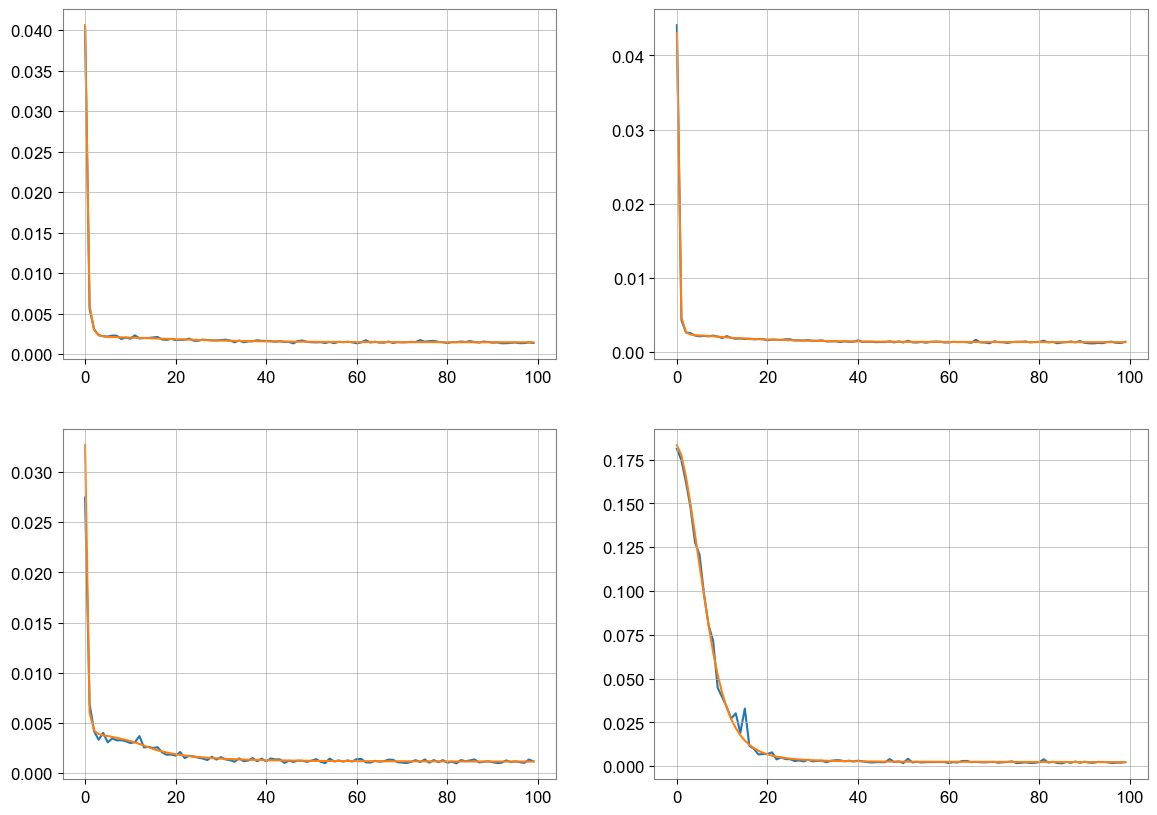

In [27]:
_, ax = plt.subplots(2, 2, figsize=(14, 10))

for index, dataset in enumerate([bkg_fft, bbh_fft, sg_fft, glitch_fft]):
    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData, trainData)
    test_dataset = TensorDataset(testData, testData)
    validation_dataset = TensorDataset(validationData, validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    loss_train = np.zeros((epochs, 1))
    loss_validation = np.zeros((epochs, 1))

    wNorm = 0;

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            # weighted_lossTrain = loss_func(decoded, x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            # output_norm = torch.norm(decoded[:, :100], dim=1) 
            # penalty_term = torch.mean((output_norm - 1) ** 2) 
            # weighted_lossTrain = lossTrain + coef_delta * penalty_term

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()

        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, _) in enumerate(validationDataLoader):
                x = x.cuda()
                encoded, decoded = autoencoder(x)
                lossVal_overall = loss_func(decoded, x)
                lossVal = lossVal_overall
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch,0] = weighted_lossTrain.item()
        loss_validation[epoch,0] = val_loss
    #     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

    torch.save(autoencoder.cuda(), "../data/4ae_%d.pt" % (index,))
    ax[index//2, index%2].plot(loss_train[:, 0])
    ax[index//2, index%2].plot(loss_validation[:, 0])
    
plt.show()

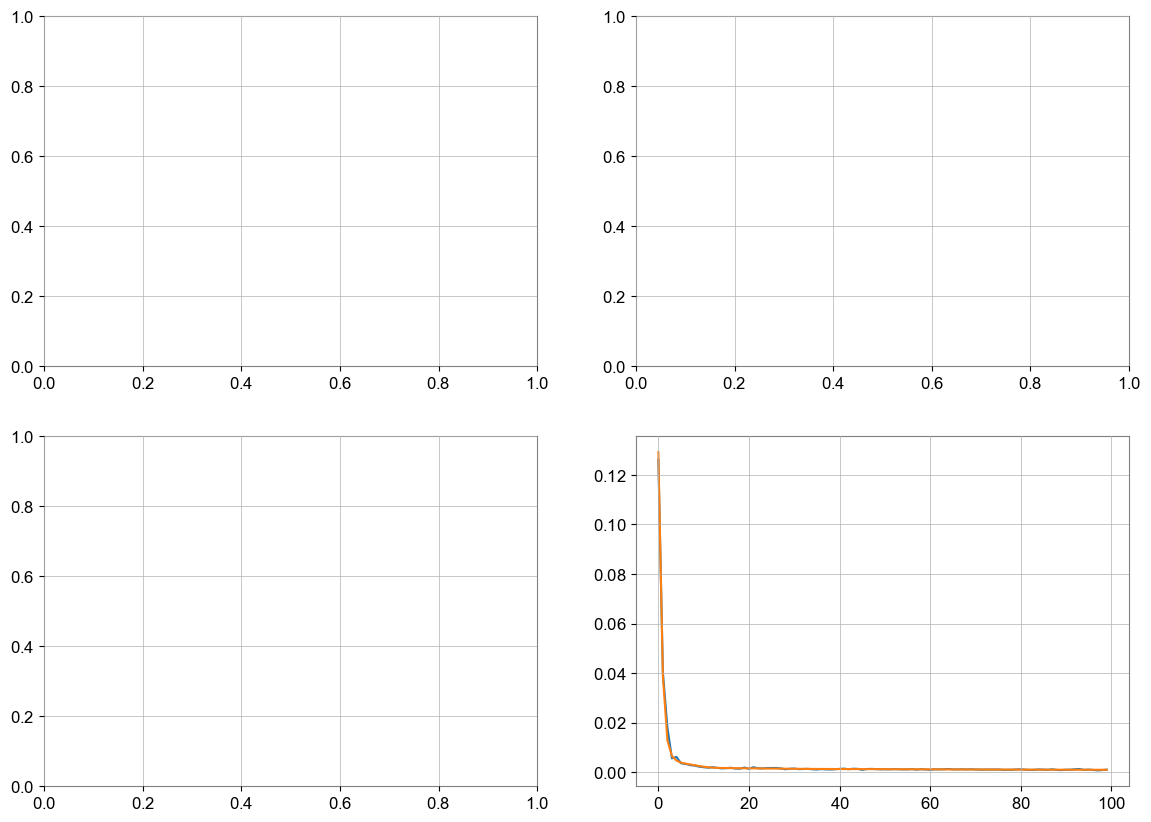

In [59]:
_, ax = plt.subplots(2, 2, figsize=(14, 10))

for index, dataset in enumerate([bkg_fft, bbh_fft, sg_fft, glitch_fft]):
    if index<3:
        continue;
    
    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData, trainData)
    test_dataset = TensorDataset(testData, testData)
    validation_dataset = TensorDataset(validationData, validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    loss_train = np.zeros((epochs, 1))
    loss_validation = np.zeros((epochs, 1))

    wNorm = 0;

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            # weighted_lossTrain = loss_func(decoded, x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            # output_norm = torch.norm(decoded[:, :100], dim=1) 
            # penalty_term = torch.mean((output_norm - 1) ** 2) 
            # weighted_lossTrain = lossTrain + coef_delta * penalty_term

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()

        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, _) in enumerate(validationDataLoader):
                x = x.cuda()
                encoded, decoded = autoencoder(x)
                lossVal_overall = loss_func(decoded, x)
                lossVal = lossVal_overall
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch,0] = weighted_lossTrain.item()
        loss_validation[epoch,0] = val_loss
    #     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

    torch.save(autoencoder.cuda(), "../data/4ae_%d.pt" % (index,))
    ax[index//2, index%2].plot(loss_train[:, 0])
    ax[index//2, index%2].plot(loss_validation[:, 0])
    
plt.show()

(0.0, 0.01)

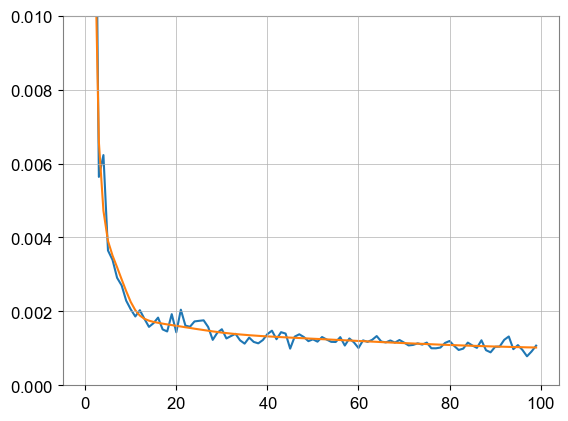

In [62]:
plt.plot(loss_train[:, 0])
plt.plot(loss_validation[:, 0])
plt.ylim(0, 0.01)

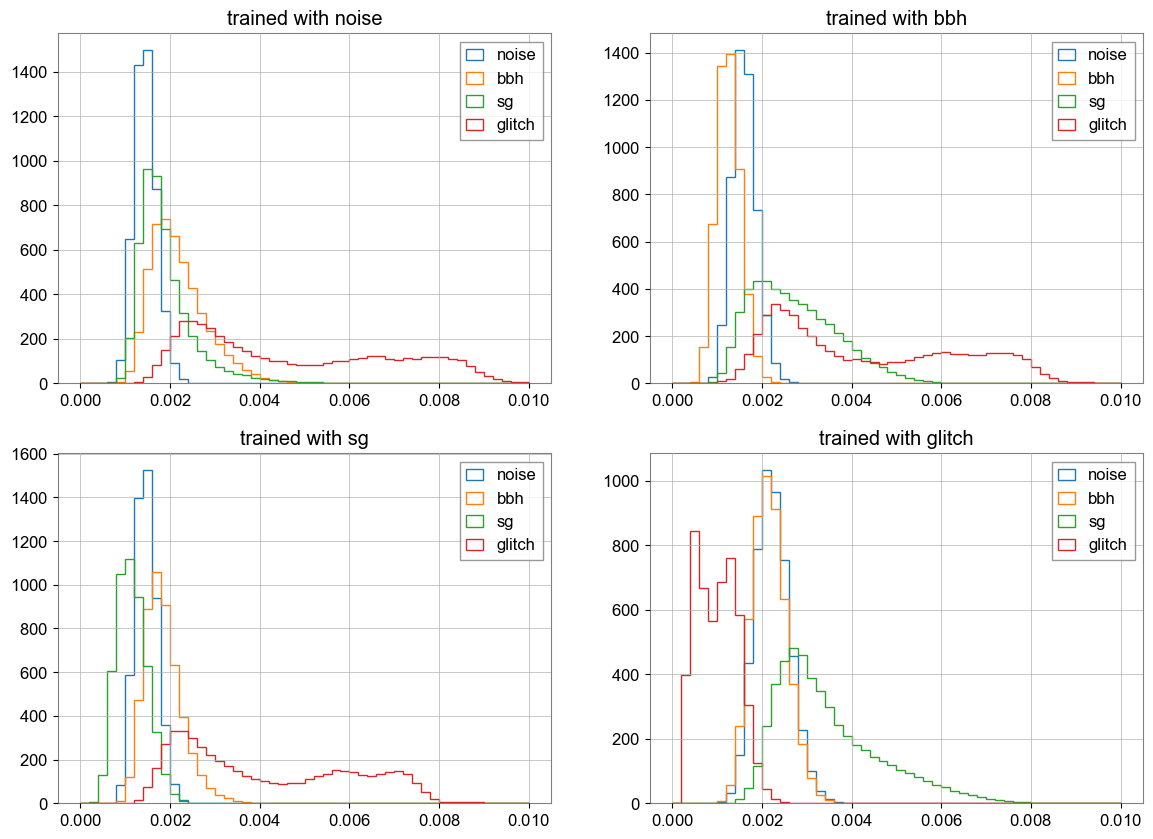

In [10]:
_, ax = plt.subplots(2, 2, figsize=(14, 10))

for index, datatype in enumerate(["noise", "bbh", "sg", "glitch"]):
    model = torch.load("../data/4ae_%d.pt" % (index,))
    model = model.cpu()
    model.eval()

    dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
    dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
    dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
    dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()
    
    foo = ax[index//2, index%2].hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    foo = ax[index//2, index%2].hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    foo = ax[index//2, index%2].hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    foo = ax[index//2, index%2].hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    ax[index//2, index%2].set_title("trained with "+datatype)
    ax[index//2, index%2].legend()

In [48]:
list_datatype = ["noise", "bbh", "sg", "glitch"];

In [20]:
Ncut = 10;

max_glitch = 0.0026;
min_glitch = 0.001;
cutList_glitch = np.linspace(min_glitch, max_glitch, Ncut);

max_sg = 0.0024;
min_sg = 0.0008;
cutList_sg = np.linspace(min_sg, max_sg, Ncut);

max_bbh = 0.0024;
min_bbh = 0.0008;
cutList_bbh = np.linspace(min_bbh, max_bbh, Ncut);

max_bkg = 0.0024;
min_bkg = 0.0006;
cutList_bkg = np.linspace(min_bkg, max_bkg, Ncut);

In [62]:
cutList = {};

cutList["glitch"] = cutList_glitch;
cutList["noise"] = cutList_bkg;
cutList["bbh"] = cutList_bbh;
cutList["sg"] = cutList_sg;

In [35]:
# preparing the dataset
# temporarily using 75% noise, 5% glitch, 10% bbh and 10% sg

perm = np.loadtxt("../data/perm_4ae_bkg.dat").astype("int");
bkg_reserved = realbkg[perm, 0][int(len(perm)*0.7):]
bkg_reserved = bkg_reserved/np.linalg.norm([bkg_reserved], axis=2).T
bkg_reserved_fft = abs(np.fft.rfft(bkg_reserved))
bkg_reserved_fft = bkg_reserved_fft/np.linalg.norm([bkg_reserved_fft], axis=2).T

perm = np.loadtxt("../data/perm_4ae_bbh.dat").astype("int");
bbh_reserved = realbbh[perm, 0][int(len(perm)*0.7):]
bbh_reserved = bbh_reserved/np.linalg.norm([bbh_reserved], axis=2).T
bbh_reserved_fft = abs(np.fft.rfft(bbh_reserved))
bbh_reserved_fft = bbh_reserved_fft/np.linalg.norm([bbh_reserved_fft], axis=2).T

perm = np.loadtxt("../data/perm_4ae_sg.dat").astype("int");
sg_reserved = realsg[perm, 0][int(len(perm)*0.7):]
sg_reserved = sg_reserved/np.linalg.norm([sg_reserved], axis=2).T
sg_reserved_fft = abs(np.fft.rfft(sg_reserved))
sg_reserved_fft = sg_reserved_fft/np.linalg.norm([sg_reserved_fft], axis=2).T

perm = np.loadtxt("../data/perm_4ae_glitch.dat").astype("int");
glitch_reserved = realglitch[perm][int(len(perm)*0.7):]
glitch_reserved = glitch_reserved/np.linalg.norm([glitch_reserved], axis=2).T
glitch_reserved_fft = abs(np.fft.rfft(glitch_reserved))
glitch_reserved_fft = glitch_reserved_fft/np.linalg.norm([glitch_reserved_fft], axis=2).T

N_bkg = len(bkg_reserved_fft);
N_glitch = int(N_bkg/25);
N_bbh = int(N_bkg*2/15);
N_sg = int(N_bkg*2/15);

testset = np.empty((N_bkg+N_glitch+N_bbh+N_sg, len(bkg_reserved_fft[0])))

s = 0;
testset[s : s+N_glitch] = glitch_reserved_fft[np.random.permutation(len(glitch_reserved_fft))[:N_glitch]];
s += N_glitch;

testset[s : s+N_bkg] = bkg_reserved_fft[np.random.permutation(len(bkg_reserved_fft))[:N_bkg]];
s += N_bkg;

testset[s : s+N_bbh] = bbh_reserved_fft[np.random.permutation(len(bbh_reserved_fft))[:N_bbh]];
s += N_bbh;

testset[s : s+N_sg] = sg_reserved_fft[np.random.permutation(len(sg_reserved_fft))[:N_sg]];
s += N_sg;

cut_points = np.cumsum([0, N_glitch, N_bkg, N_bbh, N_sg])

In [88]:
correct_ans = np.concatenate(([0]*N_glitch, [1]*N_bkg, [2]*N_bbh, [3]*N_sg))

In [41]:
models = {};
for index, datatype in enumerate(["noise", "bbh", "sg", "glitch"]): # !!!do NOT change the sequence!!!
    model = torch.load("../data/4ae_%d.pt" % (index,))
    model = model.cpu()
    model.eval()
    models[datatype] = model

In [38]:
import itertools

In [78]:
# try the series glitch-noise-bbh-sg-unknown
# the indexing below is determined by the sequence of the series network
datatype2ind = {"glitch":0, "noise":1, "bbh":2, "sg":3};
ind2datatype = {};
for key in datatype2ind.keys():
    ind2datatype[datatype2ind[key]] = key

t0 = time.time()

listResult = {};
listResult["cut"] = np.empty((Ncut**len(list_datatype), len(list_datatype)));
listResult["ans"] = np.empty((Ncut**len(list_datatype), len(testset)), dtype="int");

cnt = 0;

ic = np.zeros(4, dtype="int")

for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    for datatype in list_datatype:
        dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
        err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
    not_select = np.array([True]*len(testset));

    for i_datatype in range(len(list_datatype)):
        datatype = ind2datatype[i_datatype];
        ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[i_datatype]]);
        ans[ind_pass] = i_datatype;
        not_select[ind_pass] = False;
        
    ans[not_select] = -1;
    
    listResult["cut"][cnt] = np.array([cutList[ind2datatype[i]][ic[i]] for i in range(len(list_datatype))])
    listResult["ans"][cnt] = ans;
    cnt += 1;
    
    if (cnt+1)%100==0:
        print(time.time() - t0)
        t0 = time.time()

10.7540442943573
10.737537145614624
10.84455418586731
10.51443862915039
10.57808804512024
10.536635637283325
10.561345100402832
10.515532970428467
10.545176029205322
10.469477415084839
10.544865608215332
10.536304950714111
10.528775930404663
10.590201139450073
10.569525241851807
10.554279565811157
10.523267984390259
10.640617370605469
10.482626914978027
10.53813886642456
10.542979717254639
10.504028558731079
10.569152116775513
10.544652700424194
10.57406234741211
10.591615438461304
10.573631763458252
10.55340576171875
10.543986320495605
10.536674976348877
10.592308521270752
10.507396936416626
10.478560209274292
10.50638198852539
10.49535059928894
10.45194387435913
10.600637197494507
10.472503185272217
10.464442253112793
10.499344825744629
10.567439794540405
10.485870599746704
10.55011534690857
10.541829347610474
10.51195764541626
10.604342222213745
10.511751890182495
10.477017164230347
10.51522970199585
10.48652458190918
10.481410503387451
10.561721086502075
10.553131341934204
10.50059

In [83]:
listResult["ans"].shape

(10000, 39200)

In [94]:
listResult["accuracy_4"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);

In [167]:
np.logical_and(listResult["ans"]>-1, listResult["ans"]<2)==np.logical_and(correct_ans>-1, correct_ans<2)

array([[False,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True, False],
       [ True,  True,  True, ..., False,  True, False],
       [ True,  True,  True, ..., False,  True, False]])

In [168]:
listResult["accuracy_2"] = np.sum(np.logical_and(listResult["ans"]>-1, listResult["ans"]<2)==np.logical_and(correct_ans>-1, correct_ans<2), axis=1)/len(testset);

In [169]:
listResult["accuracy_bkg"] = np.sum(np.logical_and(listResult["ans"]>-1, listResult["ans"]<2)[:, np.logical_and(correct_ans>-1, correct_ans<2)], axis=1)/(N_glitch+N_bkg);
listResult["accuracy_sig"] = np.sum(np.logical_or(listResult["ans"]<0, listResult["ans"]>=2)[:, np.logical_or(correct_ans<0, correct_ans>=2)], axis=1)/(N_sg+N_bbh);

In [175]:
max(listResult["accuracy_2"])

0.8616836734693878

In [109]:
max(listResult["accuracy_4"])

0.8504336734693878

In [176]:
max(listResult["accuracy_bkg"])

0.9996153846153846

In [177]:
max(listResult["accuracy_sig"])

0.99975

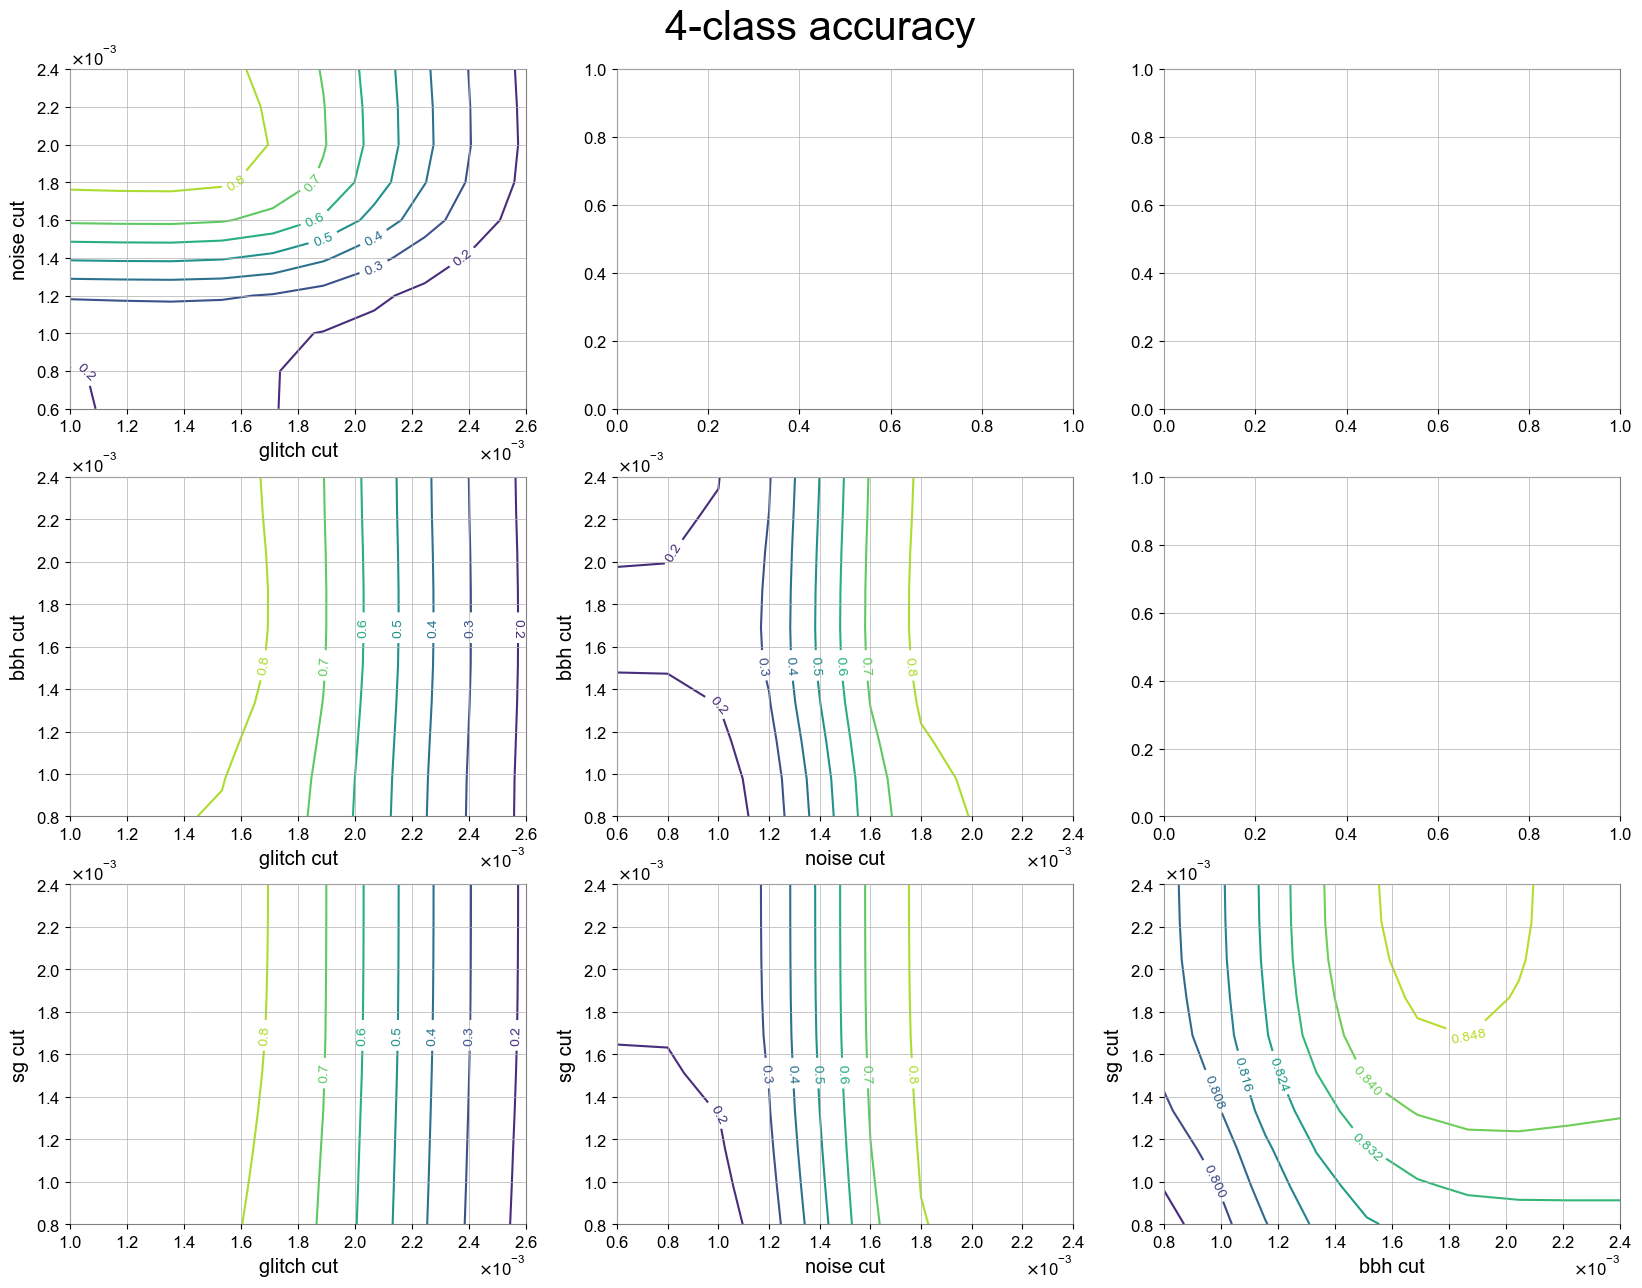

In [189]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for i in range(len(list_datatype)):
    for j in range(i+1, len(list_datatype)):
        X, Y = np.meshgrid(cutList[ind2datatype[i]], cutList[ind2datatype[j]])
        Z = np.reshape([max(listResult["accuracy_4"][np.all(listResult["cut"][:, [i,j]]==cut, axis=1)]) for cut in np.array([X.flatten(), Y.flatten()]).T], (len(Y), len(X)))
        CS = ax[j-1, i].contour(X, Y, Z)

        ax[j-1,i].clabel(CS, inline=True, fontsize=10)
        ax[j-1,i].set_xlabel(ind2datatype[i]+" cut")
        ax[j-1,i].set_ylabel(ind2datatype[j]+" cut")

fig.suptitle("4-class accuracy", fontsize=30, y=0.92)
plt.savefig("../results/contours_4-class.pdf")

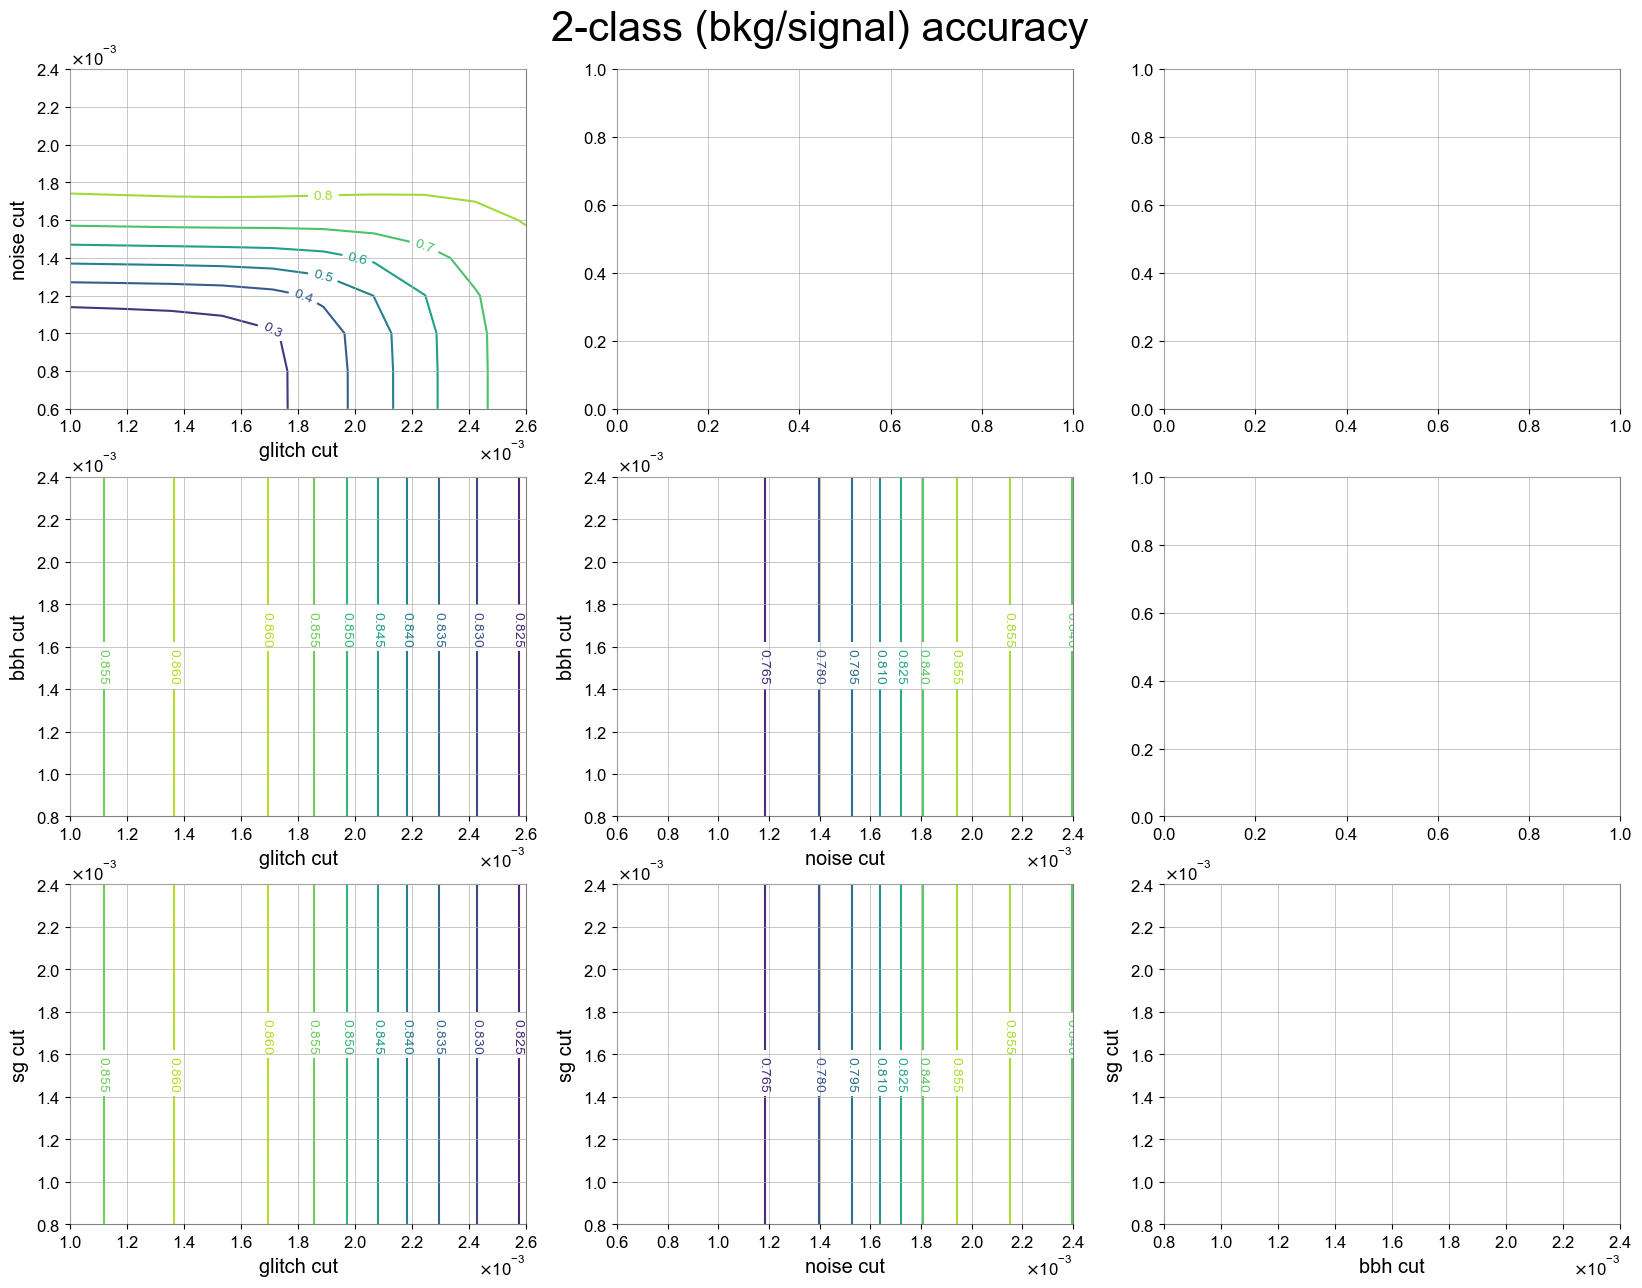

In [190]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for i in range(len(list_datatype)):
    for j in range(i+1, len(list_datatype)):
        X, Y = np.meshgrid(cutList[ind2datatype[i]], cutList[ind2datatype[j]])
        Z = np.reshape([max(listResult["accuracy_2"][np.all(listResult["cut"][:, [i,j]]==cut, axis=1)]) for cut in np.array([X.flatten(), Y.flatten()]).T], (len(Y), len(X)))
        CS = ax[j-1, i].contour(X, Y, Z)

        ax[j-1,i].clabel(CS, inline=True, fontsize=10)
        ax[j-1,i].set_xlabel(ind2datatype[i]+" cut")
        ax[j-1,i].set_ylabel(ind2datatype[j]+" cut")
        
fig.suptitle("2-class (bkg/signal) accuracy", fontsize=30, y=0.92)
plt.savefig("../results/contours_2-class.pdf")

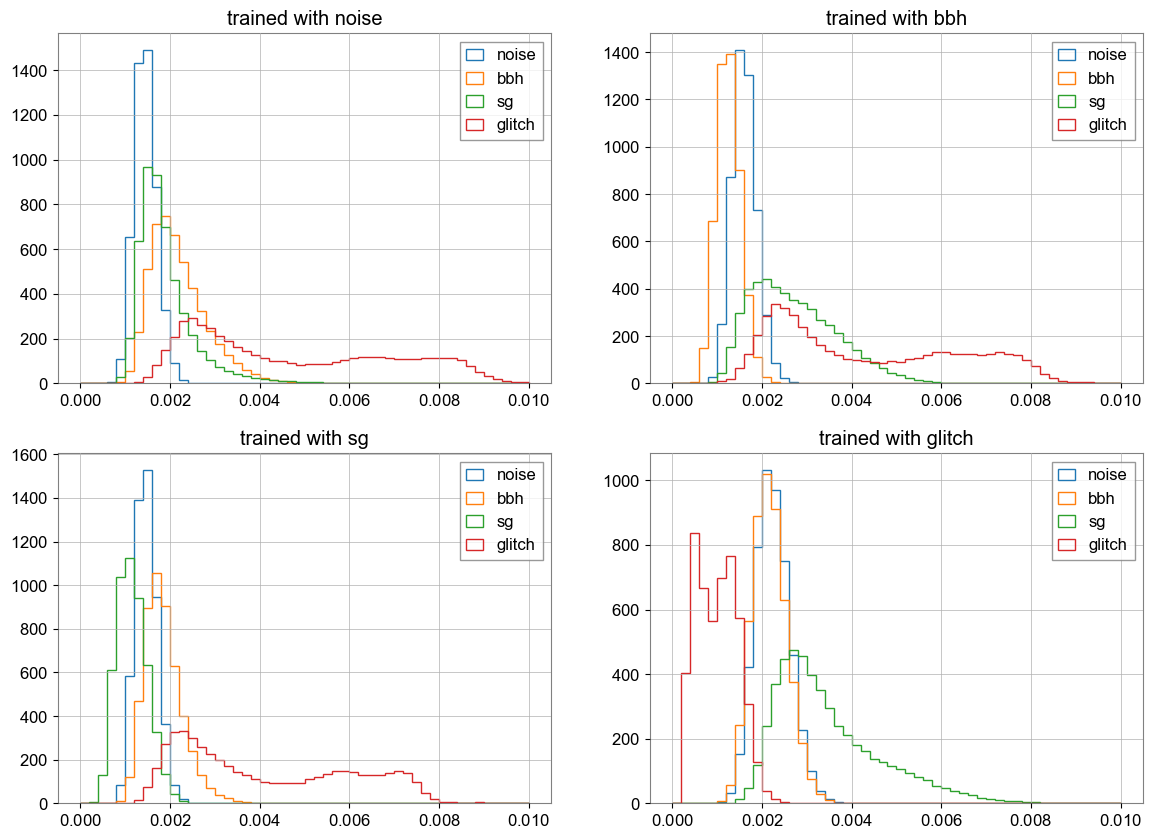

In [60]:
_, ax = plt.subplots(2, 2, figsize=(14, 10))

for index, datatype in enumerate(["noise", "bbh", "sg", "glitch"]):
    model = torch.load("../data/4ae_%d.pt" % (index,))
    model = model.cpu()
    model.eval()

    dcd_bkg = model(torch.FloatTensor(bkg_fft))[1].detach().numpy()
    dcd_bbh = model(torch.FloatTensor(bbh_fft))[1].detach().numpy()
    dcd_sg = model(torch.FloatTensor(sg_fft))[1].detach().numpy()
    dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()
    
    foo = ax[index//2, index%2].hist(np.var(bkg_fft-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
    foo = ax[index//2, index%2].hist(np.var(bbh_fft-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    foo = ax[index//2, index%2].hist(np.var(sg_fft-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    foo = ax[index//2, index%2].hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    ax[index//2, index%2].set_title("trained with "+datatype)
    ax[index//2, index%2].legend()

# Below trains with the bkg on detector 1

In [93]:
bkg_raw = np.load("../data/Datasets/background.npz")['data'][:, 1, :];
norm = np.transpose([np.linalg.norm(bkg_raw, axis = 1)]);
bkg = np.hstack((bkg_raw/norm, norm / renorm_factor))

nTotal = len(bkg);
# nTotal = len(fake_bkg);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

X_train = bkg[perm[:nTrain]]
X_test = bkg[perm[-nTest:]]
X_validation = bkg[perm[nTrain:-nTest]]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

for wNorm in [0]:#[0, 0.1, 1, 10, 100, 1000]:

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    loss_train = np.zeros((epochs, 1))
    loss_validation = np.zeros((epochs, 1))
    t0 = time.time()

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            # weighted_lossTrain = loss_func(decoded, x)
            loss_overall = loss_func(decoded, x)
            loss_norm = loss_func(decoded[:, -1], x[:, -1])
            weighted_lossTrain = loss_overall + loss_norm * wNorm

            # output_norm = torch.norm(decoded[:, :100], dim=1) 
            # penalty_term = torch.mean((output_norm - 1) ** 2) 
            # weighted_lossTrain = lossTrain + coef_delta * penalty_term

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()

        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, _) in enumerate(validationDataLoader):
                x = x.cuda()
                encoded, decoded = autoencoder(x)
                lossVal_overall = loss_func(decoded, x)
                lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
                lossVal = lossVal_overall + lossVal_norm * wNorm
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch,0] = weighted_lossTrain.item()
        loss_validation[epoch,0] = val_loss
    #     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

    print(time.time() - t0)
    print("Norm weight %f done training" % (wNorm,))
    print(autoencoder.cuda())
    torch.save(autoencoder.cuda(), "../data/model_201-40_det_1_weight_%f_renorm.pt" % (wNorm,))
    np.savetxt("../data/loss_201-40_det_1_weight_%f_renorm.dat" % (wNorm,), [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/perm_det_1_renorm.dat", perm)

1120.8076400756836
Norm weight 0.000000 done training
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=201, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=201, bias=True)
    (1): Tanh()
  )
)


# To avoid overfitting, try 101-dim (result: qualitatively similar)

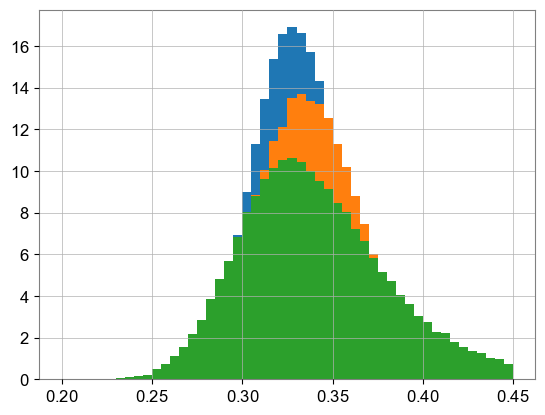

In [17]:
foo = plt.hist(norm_fakebkg, bins=50, range=(0.2, 0.45), density=True)

renorm_factor = 20;

bkg_raw = np.load("../data/Datasets/background.npz")['data'][:, 0, 50:150];
bbh_raw = np.load("../data/Datasets/bbh_for_challenge.npy")[:, 0, 50:150];

norm = np.transpose([np.linalg.norm(bkg_raw, axis = 1)]);
bkg = np.hstack((bkg_raw/norm, norm / renorm_factor))

foo = plt.hist(norm/renorm_factor, bins=50, range=(0.2, 0.45), density=True)

norm = np.transpose([np.linalg.norm(bbh_raw, axis = 1)]);
bbh = np.hstack((bbh_raw/norm, norm / renorm_factor))

foo = plt.hist(norm/renorm_factor, bins=50, range=(0.2, 0.45), density=True)

nTotal = len(bkg);
# nTotal = len(fake_bkg);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

X_train = bkg[perm[:nTrain]]
X_test = bkg[perm[-nTest:]]
X_validation = bkg[perm[nTrain:-nTest]]

# X_train = fake_bkg[perm[:nTrain]]
# X_test = fake_bkg[perm[-nTest:]]
# X_validation = fake_bkg[perm[nTrain:-nTest]]

## test 101-20-101

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [18]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

wNorm = 0;

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall + loss_norm * wNorm

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall + lossVal_norm * wNorm
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
#     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

print(time.time() - t0)

# print("Norm weight %f done training" % (wNorm,))
# print(autoencoder.cuda())
# torch.save(autoencoder.cuda(), "../data/model_201-40_weight_%f_fakebkg.pt" % (wNorm,))
# np.savetxt("../data/loss_201-40_weight_%f_fakebkg.dat" % (wNorm,), [loss_train[:, 0], loss_validation[:, 0]])
    
# np.savetxt("../data/perm_fakebkg.dat", perm)

561.9412305355072


In [22]:
ae_cpu = autoencoder.to('cpu')

In [27]:
bkg.shape

(100000, 101)

In [28]:
decoded_bkg.shape

torch.Size([100000, 101])

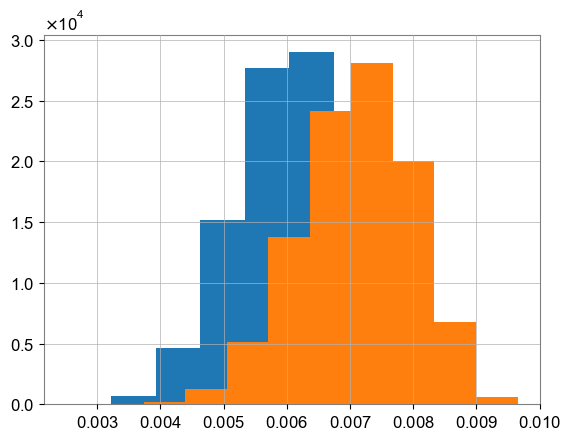

In [29]:
autoencoder.eval()

_, decoded_bkg = autoencoder(torch.FloatTensor(bkg))
_, decoded_bbh = autoencoder(torch.FloatTensor(bbh))

foo = plt.hist(np.linalg.norm(decoded_bkg.double().detach().numpy()[:, :100] - bkg[:, :100], axis = 1)**2 / 100)
foo = plt.hist(np.linalg.norm(decoded_bbh.double().detach().numpy()[:, :100] - bbh[:, :100], axis = 1)**2 / 100)

plt.show()

## try 20, 40, 60 for the latent space

In [75]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

wNorm = 10;

decoded_bkg = np.empty((3,)+bkg.shape)
decoded_bbh = np.empty((3,)+bbh.shape)

list_nLS = [20, 40, 60]

for i in range(3):
    nLatentSpace = list_nLS[i];
    
    class AEtest(nn.Module):
        def __init__(self):
            super(AEtest, self).__init__()
            self.encoder = nn.Sequential(
                nn.Linear(101, nLatentSpace),
                nn.ReLU()
            )
            self.decoder = nn.Sequential(
                nn.Linear(nLatentSpace, 101),
                nn.Tanh()
            )

        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return encoded, decoded
    
    autoencoder = AEtest().cuda()
    print(autoencoder)

#     autoencoder = listAE[iAE];
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    loss_train = np.zeros((epochs, 1))
    loss_validation = np.zeros((epochs, 1))
    
    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            # weighted_lossTrain = loss_func(decoded, x)
            loss_overall = loss_func(decoded, x)
            loss_norm = loss_func(decoded[:, -1], x[:, -1])
            weighted_lossTrain = loss_overall + loss_norm * wNorm

            # output_norm = torch.norm(decoded[:, :100], dim=1) 
            # penalty_term = torch.mean((output_norm - 1) ** 2) 
            # weighted_lossTrain = lossTrain + coef_delta * penalty_term

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()

        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, _) in enumerate(validationDataLoader):
                x = x.cuda()
                encoded, decoded = autoencoder(x)
                lossVal_overall = loss_func(decoded, x)
                lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
                lossVal = lossVal_overall + lossVal_norm * wNorm
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch,0] = weighted_lossTrain.item()
        loss_validation[epoch,0] = val_loss
        
    autoencoder.to("cpu")
    autoencoder.eval()

    decoded_bkg[i] = autoencoder(torch.FloatTensor(bkg))[1].double().detach().numpy()
    decoded_bbh[i] = autoencoder(torch.FloatTensor(bbh))[1].double().detach().numpy()


AEtest(
  (encoder): Sequential(
    (0): Linear(in_features=101, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=101, bias=True)
    (1): Tanh()
  )
)
AEtest(
  (encoder): Sequential(
    (0): Linear(in_features=101, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=101, bias=True)
    (1): Tanh()
  )
)
AEtest(
  (encoder): Sequential(
    (0): Linear(in_features=101, out_features=60, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=60, out_features=101, bias=True)
    (1): Tanh()
  )
)


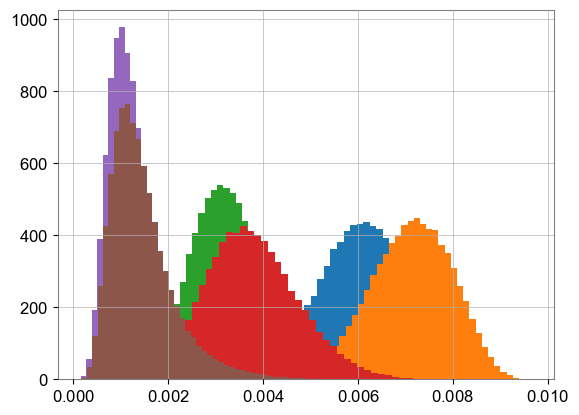

In [56]:
for i in range(3):
    foo = plt.hist(np.linalg.norm(decoded_bkg[i, :, :100] - bkg[:, :100], axis = 1)**2 / 100, bins=50, density=True)
    foo = plt.hist(np.linalg.norm(decoded_bbh[i, :, :100] - bbh[:, :100], axis = 1)**2 / 100, bins=50, density=True)
    
plt.show()

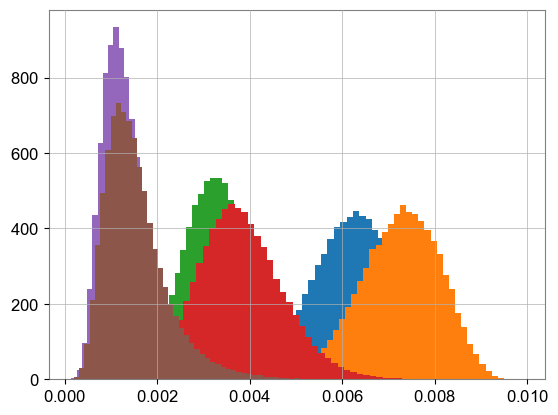

In [76]:
# wNorm = 10
for i in range(3):
    foo = plt.hist(np.linalg.norm(decoded_bkg[i, :, :100] - bkg[:, :100], axis = 1)**2 / 100, bins=50, density=True)
    foo = plt.hist(np.linalg.norm(decoded_bbh[i, :, :100] - bbh[:, :100], axis = 1)**2 / 100, bins=50, density=True)
    
plt.show()

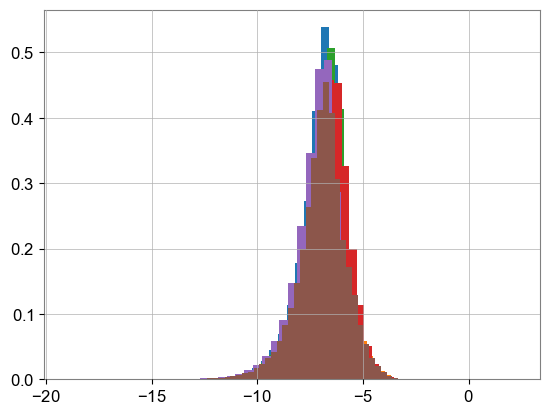

In [77]:
for i in range(3):
    foo = plt.hist(np.log10((decoded_bkg[i, :, -1] - bkg[:, -1])**2), bins=50, density=True)
    foo = plt.hist(np.log10((decoded_bbh[i, :, -1] - bbh[:, -1])**2), bins=50, density=True)
    
plt.show()

# Below starts the training of 200-40-200

### Note that in this case there's no need to impose the norm weight

In [75]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(200, 40),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(40, 200),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [76]:
fake_bkg = np.load("../data/4000Hz25msnoisesample1e6.npy")[100:2*10**5].reshape((10**5-50, 200)) * 1e21

In [77]:
nTotal = len(bkg);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

# X_train = bkg[perm[:nTrain]]
# X_test = bkg[perm[-nTest:]]
# X_validation = bkg[perm[nTrain:-nTest]]

X_train = bkg_raw[perm[:nTrain]]
X_test = bkg_raw[perm[-nTest:]]
X_validation = bkg_raw[perm[nTrain:-nTest]]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall #+ loss_norm * wNorm

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall #+ lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
#     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

print(time.time() - t0)
print(autoencoder.cuda())
torch.save(autoencoder.cuda(), "../data/model_200-40_raw.pt")
np.savetxt("../data/loss_200-40_raw.dat", [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/perm_200-40_raw.dat", perm)

992.5381164550781
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=200, bias=True)
    (1): Tanh()
  )
)


In [79]:
renorm_factor

20

In [80]:
nTotal = len(bkg);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

# X_train = bkg[perm[:nTrain]]
# X_test = bkg[perm[-nTest:]]
# X_validation = bkg[perm[nTrain:-nTest]]

X_train = bkg_raw[perm[:nTrain]] / renorm_factor
X_test = bkg_raw[perm[-nTest:]] / renorm_factor
X_validation = bkg_raw[perm[nTrain:-nTest]] / renorm_factor

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall #+ loss_norm * wNorm

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall #+ lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
#     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

print(time.time() - t0)
print(autoencoder.cuda())
torch.save(autoencoder.cuda(), "../data/model_200-40_renorm.pt")
np.savetxt("../data/loss_200-40_renorm.dat", [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/perm_200-40_renorm.dat", perm)

939.0159349441528
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=40, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=200, bias=True)
    (1): Tanh()
  )
)


In [81]:
nTotal = len(fake_bkg);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

perm = np.random.permutation(nTotal)

# X_train = bkg[perm[:nTrain]]
# X_test = bkg[perm[-nTest:]]
# X_validation = bkg[perm[nTrain:-nTest]]

X_train = fake_bkg[perm[:nTrain], :200]
X_test = fake_bkg[perm[-nTest:], :200]
X_validation = fake_bkg[perm[nTrain:-nTest], :200]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))
t0 = time.time()

for epoch in range(epochs):

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall #+ loss_norm * wNorm

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall #+ lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
#     print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

print(time.time() - t0)
print(autoencoder.cuda())
torch.save(autoencoder.cuda(), "../data/model_200-40_fakebkg.pt")
np.savetxt("../data/loss_200-40_fakebkg.dat", [loss_train[:, 0], loss_validation[:, 0]])
    
np.savetxt("../data/perm_200-40_fakebkg.dat", perm)

KeyboardInterrupt: 

In [8]:
def TPR_calculation(noise_distribution, signal_distribution, FPR):
    threshold_rank = len(noise_distribution) * FPR
    threshold = np.partition(noise_distribution, -threshold_rank)[-threshold_rank]
    
    TPR = np.argwhere(signal_distribution > threshold).shape[0] / len(signal_distribution)
    
    return TPR

In [30]:
data_for_training_and_testing = np.load("../data/4000Hz25msnoisesample.npy") * 1e21

In [19]:
# data_for_training_and_testing = np.load("../data/4000Hz25msnoisesample1e6.npy") * 1e21

In [9]:
# data_injected = np.delete(np.load("../Data_cached/4000Hz25msdatasampleBBH.npy") * 1e21, 47, axis = 0)

In [10]:
data_injected = np.load("../data/4000Hz25msdatasampleBBH3346.npy") * 1e21

In [31]:
data_for_training_and_testing.shape

(10000, 100)

In [32]:
total_sample_number = data_for_training_and_testing.shape[0]
test_sample_number = int(test_sample_ratio * total_sample_number)
validation_sample_number = int(validation_sample_ratio * total_sample_number)
train_sample_number = total_sample_number - test_sample_number - validation_sample_number


X_train_ini = data_for_training_and_testing[0:train_sample_number].copy()
X_test_ini = data_for_training_and_testing[-test_sample_number:].copy()
X_validation_ini = data_for_training_and_testing[train_sample_number:-test_sample_number].copy()

In [33]:
bkg_normed, _, bkg_norm = bunch_normalization(data_for_training_and_testing)
bkg_with_norm = np.hstack((bkg_normed, np.array([bkg_norm]).transpose()))

In [34]:
perm = np.random.permutation(total_sample_number)

X_train = bkg_with_norm[:train_sample_number]
X_test = bkg_with_norm[-test_sample_number:]
X_validation = bkg_with_norm[train_sample_number:-test_sample_number]

In [35]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

In [36]:
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))

for epoch in range(epochs):
    t0 = time.time()
    # 训练阶段
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall + loss_norm * coef_delta
        
        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term
        
        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    # 验证阶段
    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall + lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)
    
    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))
    
    print(time.time() - t0)

Epoch: 0001, Training loss=0.02217066, Validation loss=0.02270779
0.7844910621643066
Epoch: 0002, Training loss=0.01996162, Validation loss=0.02012685
0.7868080139160156
Epoch: 0003, Training loss=0.01721187, Validation loss=0.01762725
0.6508562564849854
Epoch: 0004, Training loss=0.01492085, Validation loss=0.01521217
0.6487612724304199
Epoch: 0005, Training loss=0.01295313, Validation loss=0.01318835
0.6243758201599121
Epoch: 0006, Training loss=0.01165853, Validation loss=0.01172066
0.4592752456665039
Epoch: 0007, Training loss=0.01116580, Validation loss=0.01072881
0.6943004131317139
Epoch: 0008, Training loss=0.01011062, Validation loss=0.01011174
0.6722371578216553
Epoch: 0009, Training loss=0.00961590, Validation loss=0.00972080
0.5509111881256104
Epoch: 0010, Training loss=0.00960462, Validation loss=0.00946460
0.5597512722015381
Epoch: 0011, Training loss=0.00906902, Validation loss=0.00926920
0.5272517204284668
Epoch: 0012, Training loss=0.00911178, Validation loss=0.00911032

Epoch: 0098, Training loss=0.00793480, Validation loss=0.00793177
0.6712296009063721
Epoch: 0099, Training loss=0.00787653, Validation loss=0.00791813
0.6022076606750488
Epoch: 0100, Training loss=0.00760934, Validation loss=0.00792396
0.6179549694061279
Epoch: 0101, Training loss=0.00773727, Validation loss=0.00792648
0.5620782375335693
Epoch: 0102, Training loss=0.00787002, Validation loss=0.00792568
0.5542678833007812
Epoch: 0103, Training loss=0.00774764, Validation loss=0.00792061
0.5499720573425293
Epoch: 0104, Training loss=0.00786893, Validation loss=0.00791904
0.5498592853546143
Epoch: 0105, Training loss=0.00779923, Validation loss=0.00792979
0.5548520088195801
Epoch: 0106, Training loss=0.00781604, Validation loss=0.00792018
0.5489993095397949
Epoch: 0107, Training loss=0.00777602, Validation loss=0.00792749
0.640080451965332
Epoch: 0108, Training loss=0.00763654, Validation loss=0.00792203
0.5939502716064453
Epoch: 0109, Training loss=0.00783708, Validation loss=0.00792725


Epoch: 0195, Training loss=0.00784629, Validation loss=0.00790866
0.4901440143585205
Epoch: 0196, Training loss=0.00772006, Validation loss=0.00791074
0.5092020034790039
Epoch: 0197, Training loss=0.00782944, Validation loss=0.00791173
0.5314247608184814
Epoch: 0198, Training loss=0.00778346, Validation loss=0.00791092
0.5661709308624268
Epoch: 0199, Training loss=0.00772742, Validation loss=0.00790552
0.5188450813293457
Epoch: 0200, Training loss=0.00754397, Validation loss=0.00791170
0.43898749351501465


In [38]:
data_real_bkg = np.load("../data/Datasets/background.npz")
data_real_bbh = np.load("../data/Datasets/bbh_for_challenge.npy")
data_real_sg = np.load("../data/Datasets/sglf_for_challenge.npy")

In [43]:
data_real_bkg.items()

ItemsView(<numpy.lib.npyio.NpzFile object at 0x00000223D2B8B410>)

In [23]:
max(np.linalg.norm(train_glitch_sample, axis = 1))

0.9999999999999999

In [111]:
max(train_glitch_sample.flatten())

0.6628917094251212

In [24]:
random_integers = np.random.choice(range(7000), size=350, replace=False)

In [25]:
random_integers_2 = np.random.choice(range(2000), size=100, replace=False)

In [26]:
random_integers_3 = np.random.choice(range(1000), size=50, replace=False)

In [27]:
random_integers_3

array([474, 957, 741, 254, 512, 481, 108, 892, 893,  23, 538,
       417, 477, 734, 756, 297, 143, 913, 786, 766, 574, 612,
       506, 408, 817, 346, 583, 899,  29, 528,  15, 310, 166,
       904, 221, 156, 211, 594, 854, 792, 947, 547, 781, 729,
        93, 690, 490, 407, 862, 412])

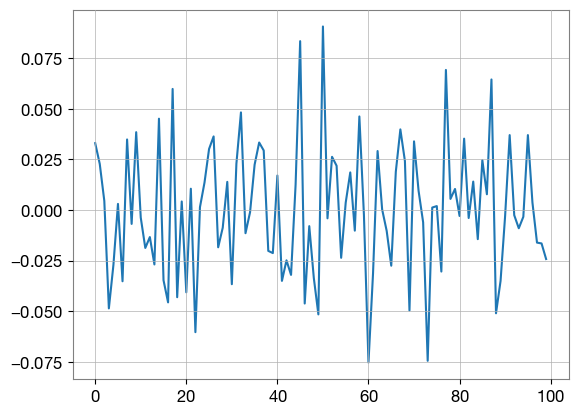

In [124]:
plt.plot(X_validation_ini[181])

In [128]:
random_integers_3.shape

(500,)

In [28]:
X_train_replaced = X_train_ini.copy()
X_train_replaced[random_integers] = train_glitch_sample[0:350]

In [29]:
X_test_replaced = X_test_ini.copy()
X_test_replaced[random_integers_2] = train_glitch_sample[400:500]

In [30]:
X_validation_replaced = X_validation_ini.copy()
X_validation_replaced[random_integers_3] = train_glitch_sample[350:400]

In [31]:
X_validation_replaced.shape

(1000, 100)

In [75]:
# X_train_replaced = train_glitch_sample

In [79]:
# X_train, X_train_recover_min, X_train_recover_coef = bunch_normalization(X_train_replaced)
# X_test, X_test_recover_min, X_test_recover_coef = bunch_normalization(X_test_replaced)
# X_validation, X_validation_recover_min, X_validation_recover_coef = bunch_normalization(X_validation_replaced)
# data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())

In [78]:
# X_train.shape

(500, 100)

In [32]:
# X_train, X_train_recover_min, X_train_recover_coef = bunch_normalization(X_train_replaced)
# X_test, X_test_recover_min, X_test_recover_coef = bunch_normalization(X_test_replaced)
# X_validation, X_validation_recover_min, X_validation_recover_coef = bunch_normalization(X_validation_replaced)
# data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())

In [19]:
X_train, X_train_recover_min, X_train_recover_coef = bunch_normalization(X_train_ini)
X_test, X_test_recover_min, X_test_recover_coef = bunch_normalization(X_test_ini)
X_validation, X_validation_recover_min, X_validation_recover_coef = bunch_normalization(X_validation_ini)
data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())

In [81]:
X_train = np.hstack((X_train, np.array(X_train_recover_coef).reshape(train_sample_number,1)))
X_validation = np.hstack((X_validation, np.array(X_validation_recover_coef).reshape(validation_sample_number,1)))
X_test = np.hstack((X_test, np.array(X_test_recover_coef).reshape(test_sample_number,1)))
data_injected_normalized = np.hstack((data_injected_normalized, np.array(junk2).reshape(len(data_injected),1)))

In [20]:
# X_train = np.hstack((X_train, np.array(X_train_recover_coef).reshape(train_sample_number,1)))
# X_validation = np.hstack((X_validation, np.array(X_validation_recover_coef).reshape(validation_sample_number,1)))
# X_test = np.hstack((X_test, np.array(X_test_recover_coef).reshape(test_sample_number,1)))
# data_injected_normalized = np.hstack((data_injected_normalized, np.array(X_train_recover_coef)[0:len(data_injected)].reshape(len(data_injected),1)))

In [45]:
# X_train = np.hstack((X_train, np.ones((train_sample_number, 1))))
# X_validation = np.hstack((X_validation, np.ones((validation_sample_number, 1))))
# X_test = np.hstack((X_test, np.ones((test_sample_number, 1))))
# data_injected_normalized = np.hstack((data_injected_normalized, np.ones((len(data_injected), 1))))

In [165]:
np.savez('../Data_cached/uninorm_dataset_cached.npz', train = X_train, validation = X_validation, test = X_test, BBH = data_injected_normalized, SG = data_sinegaussian_normalized, simulated_glitches = data_glitches_normalized, real_glitches = data_glitches_real_normalized)

In [430]:
data_file = np.load('../Data_cached/uninorm_dataset_cached.npz')

In [431]:
X_train, X_test, data_injected_normalized, data_sinegaussian_normalized, data_glitches_normalized, data_glitches_real_normalized = data_file['train'], data_file['test'], data_file['BBH'], data_file['SG'], data_file['simulated_glitches'], data_file['real_glitches']

In [432]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

In [22]:
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))


for epoch in range(epochs):
    # 训练阶段
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall + loss_norm * coef_delta
        
        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term
        
        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    # 验证阶段
    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall + lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)
    
    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

Epoch: 0001, Training loss=0.00791089, Validation loss=0.00789967
Epoch: 0002, Training loss=0.00779289, Validation loss=0.00789402
Epoch: 0003, Training loss=0.00787645, Validation loss=0.00789183
Epoch: 0004, Training loss=0.00779505, Validation loss=0.00788969
Epoch: 0005, Training loss=0.00794173, Validation loss=0.00788823
Epoch: 0006, Training loss=0.00796271, Validation loss=0.00788735
Epoch: 0007, Training loss=0.00776560, Validation loss=0.00788669
Epoch: 0008, Training loss=0.00787914, Validation loss=0.00788613
Epoch: 0009, Training loss=0.00781101, Validation loss=0.00788495
Epoch: 0010, Training loss=0.00785976, Validation loss=0.00788512
Epoch: 0011, Training loss=0.00786832, Validation loss=0.00788368
Epoch: 0012, Training loss=0.00800549, Validation loss=0.00788378
Epoch: 0013, Training loss=0.00767947, Validation loss=0.00788358
Epoch: 0014, Training loss=0.00798490, Validation loss=0.00788337
Epoch: 0015, Training loss=0.00807306, Validation loss=0.00788296
Epoch: 001

In [25]:
torch.save(autoencoder.cpu(), '../Model_cached/model_101_20_101_uninorm.pt')

In [215]:
autoencoder = torch.load('../Model_cached/model_101_20_101_uninorm.pt')

In [42]:
autoencoder = autoencoder.cpu()

In [ ]:
loss_func()

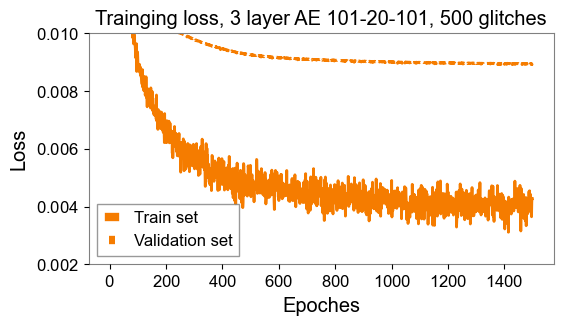

In [94]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE 101-20-101, 500 glitches')
plt.ylim(0.002,0.01)
plt.legend()
plt.show()